In [1]:
!pip install imutils

from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import VGG16, InceptionV3, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

In [2]:
!mkdir /tmp/prepared_data/

!mkdir /tmp/prepared_data/benign
!mkdir /tmp/prepared_data/PreB
!mkdir /tmp/prepared_data/ProB
!mkdir /tmp/prepared_data/EarlyPreB

!mkdir /tmp/prepared_test/

!mkdir /tmp/prepared_test/benign
!mkdir /tmp/prepared_test/PreB
!mkdir /tmp/prepared_test/ProB
!mkdir /tmp/prepared_test/EarlyPreB

In [4]:
data_dir = r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))

random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.9, shuffle=True, random_state=88)

print(f"number of train list: {len(train_list)}")
print(f"number of test list.: {len(test_list)}")

number of train list: 2917
number of test list.: 325


In [5]:
print(f"Number of samples in dataset: {len(list(paths.list_images(r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]')))}",'\n')

print(f"Number of samples of each class:",'\n')

print(f"#1 Benign ----------------: {len(list(paths.list_images(r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/Benign')))}")
print(f"#2 [Malignant] Pre-B -----: {len(list(paths.list_images(r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pre-B')))}")
print(f"#3 [Malignant] Pro-B -----: {len(list(paths.list_images(r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] Pro-B')))}")
print(f"#4 [Malignant] early Pre B: {len(list(paths.list_images(r'/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]/[Malignant] early Pre-B')))}")

Number of samples in dataset: 3242 

Number of samples of each class: 

#1 Benign ----------------: 512
#2 [Malignant] Pre-B -----: 955
#3 [Malignant] Pro-B -----: 796
#4 [Malignant] early Pre B: 979


In [6]:
import os
import cv2

p = 0

for img in test_list[:]:
    i = cv2.imread(img)
    if i is None:
        print(f"Warning: Cannot read image {img}")
        continue  

    i = cv2.resize(i, (224, 224))
    lable = img.split(os.path.sep)[-2]  

    if lable == "Benign":
        b = f"/tmp/prepared_test/benign/{lable}{p}.png"
    elif lable == "[Malignant] Pre-B":
        b = f"/tmp/prepared_test/PreB/{lable}{p}.png"
    elif lable == "[Malignant] Pro-B":
        b = f"/tmp/prepared_test/ProB/{lable}{p}.png"
    elif lable == "[Malignant] early Pre-B":
        b = f"/tmp/prepared_test/EarlyPreB/{lable}{p}.png"
    else:
        print(f"Warning: Label {lable} not recognized for {img}")
        continue  # Bỏ qua ảnh có nhãn không hợp lệ

    p += 1
    cv2.imwrite(b, i)
    print(f"Saved: {b},{p}")


Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B0.png,1
Saved: /tmp/prepared_test/EarlyPreB/[Malignant] early Pre-B1.png,2
Saved: /tmp/prepared_test/EarlyPreB/[Malignant] early Pre-B2.png,3
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B3.png,4
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B4.png,5
Saved: /tmp/prepared_test/EarlyPreB/[Malignant] early Pre-B5.png,6
Saved: /tmp/prepared_test/ProB/[Malignant] Pro-B6.png,7
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B7.png,8
Saved: /tmp/prepared_test/benign/Benign8.png,9
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B9.png,10
Saved: /tmp/prepared_test/EarlyPreB/[Malignant] early Pre-B10.png,11
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B11.png,12
Saved: /tmp/prepared_test/ProB/[Malignant] Pro-B12.png,13
Saved: /tmp/prepared_test/EarlyPreB/[Malignant] early Pre-B13.png,14
Saved: /tmp/prepared_test/PreB/[Malignant] Pre-B14.png,15
Saved: /tmp/prepared_test/ProB/[Malignant] Pro-B15.png,16
Saved: /tmp/prepared_test/ProB/[Malignant] Pr

In [7]:
import os
import cv2
import time
import numpy as np
from sklearn.cluster import KMeans
from scipy.ndimage import binary_fill_holes
from skimage import morphology

p = 0
tic = time.perf_counter()

for img in train_list:
    i = cv2.imread(img)
    if i is None:
        print(f"Warning: Cannot read image {img}")
        continue 

    i = cv2.resize(i, (224, 224))

    lable = img.split(os.path.sep)[-2]

    if lable == "Benign":
        save_dir = "/tmp/prepared_data/benign"
    elif lable == "[Malignant] Pre-B":
        save_dir = "/tmp/prepared_data/PreB"
    elif lable == "[Malignant] Pro-B":
        save_dir = "/tmp/prepared_data/ProB"
    elif lable == "[Malignant] early Pre-B":
        save_dir = "/tmp/prepared_data/EarlyPreB"
    else:
        print(f"Warning: Unrecognized label {lable} for {img}")
        continue

    os.makedirs(save_dir, exist_ok=True)  # Tạo thư mục nếu chưa có

    # Lưu ảnh gốc (raw image)
    raw_filename = f"{save_dir}/{lable}_{p}.png"
    cv2.imwrite(raw_filename, i)
    print(f"Saved raw: {raw_filename}")
    p += 1

    # -------- Segmentation ---------
    i_rgb = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i_rgb, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(i_lab)
    i2 = a_channel.reshape(-1, 1)

    km = KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s = km.cluster_centers_[km.labels_]
    ic = p2s.reshape(a_channel.shape).astype(np.uint8)

    ret, t_img = cv2.threshold(ic, 141, 255, cv2.THRESH_BINARY)
    fh = binary_fill_holes(t_img)
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1, 250)
    m2 = m2.astype(np.uint8)

    out = cv2.bitwise_and(i_rgb, i_rgb, mask=m2)
    out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)

    # Lưu ảnh đã segment
    seg_filename = f"{save_dir}/{lable}_{p}_seg.png"
    cv2.imwrite(seg_filename, out)
    print(f"Saved segmented: {seg_filename}")
    p += 1

toc2 = time.perf_counter()
print(f"{p} samples processed in {((toc2 - tic)/60):.2f} minutes")

Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_0.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_6.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_7_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_8.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_9_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_10.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_11_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_12.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_13_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_14.png
Saved segmented: /tmp/prepared_data/benign/Benign_15_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_16.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_17_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_18.png
Saved segmented: /tmp/prepared_data/benign/Benign_19_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_20.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_21_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_22.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_23_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_24.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_25_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_26.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_27_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_28.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_29_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_30.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_31_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_32.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_33_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_34.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_35_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_36.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_37_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_38.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_39_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_40.png
Saved segmented: /tmp/prepared_data/benign/Benign_41_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_42.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_43_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_44.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_45_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_46.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_47_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_48.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_49_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_50.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_51_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_52.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_53_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_54.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_55_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_56.png
Saved segmented: /tmp/prepared_data/benign/Benign_57_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_58.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_59_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_60.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_61_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_62.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_63_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_64.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_65_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_66.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_67_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_68.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_69_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_70.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_71_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_72.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_73_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_74.png
Saved segmented: /tmp/prepared_data/benign/Benign_75_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_76.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_77_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_78.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_79_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_80.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_81_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_82.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_83_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_84.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_85_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_86.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_87_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_88.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_89_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_90.png
Saved segmented: /tmp/prepared_data/benign/Benign_91_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_92.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_93_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_94.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_95_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_96.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_97_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_98.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_99_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_100.png
Saved segmented: /tmp/prepared_data/benign/Benign_101_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_102.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_103_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_104.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_105_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_106.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_107_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_108.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_109_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_110.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_111_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_112.png
Saved segmented: /tmp/prepared_data/benign/Benign_113_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_114.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_115_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_116.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_117_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_118.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_119_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_120.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_121_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_122.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_123_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_124.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_125_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_126.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_127_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_128.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_129_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_130.png
Saved segmented: /tmp/prepared_data/benign/Benign_131_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_132.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_133_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_134.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_135_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_136.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_137_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_138.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_139_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_140.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_141_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_142.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_143_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_144.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_145_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_146.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_147_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_148.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_149_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_150.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_151_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_152.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_153_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_154.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_155_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_156.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_157_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_158.png
Saved segmented: /tmp/prepared_data/benign/Benign_159_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_160.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_161_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_162.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_163_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_164.png
Saved segmented: /tmp/prepared_data/benign/Benign_165_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_166.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_167_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_168.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_169_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_170.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_171_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_172.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_173_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_174.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_175_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_176.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_177_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_178.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_179_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_180.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_181_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_182.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_183_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_184.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_185_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_186.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_187_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_188.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_189_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_190.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_191_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_192.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_193_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_194.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_195_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_196.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_197_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_198.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_199_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_200.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_201_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_202.png
Saved segmented: /tmp/prepared_data/benign/Benign_203_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_204.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_205_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_206.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_207_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_208.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_209_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_210.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_211_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_212.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_213_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_214.png
Saved segmented: /tmp/prepared_data/benign/Benign_215_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_216.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_217_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_218.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_219_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_220.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_221_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_222.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_223_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_224.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_225_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_226.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_227_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_228.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_229_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_230.png
Saved segmented: /tmp/prepared_data/benign/Benign_231_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_232.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_233_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_234.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_235_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_236.png
Saved segmented: /tmp/prepared_data/benign/Benign_237_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_238.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_239_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_240.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_241_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_242.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_243_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_244.png
Saved segmented: /tmp/prepared_data/benign/Benign_245_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_246.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_247_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_248.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_249_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_250.png
Saved segmented: /tmp/prepared_data/benign/Benign_251_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_252.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_253_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_254.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_255_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_256.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_257_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_258.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_259_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_260.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_261_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_262.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_263_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_264.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_265_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_266.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_267_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_268.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_269_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_270.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_271_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_272.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_273_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_274.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_275_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_276.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_277_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_278.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_279_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_280.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_281_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_282.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_283_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_284.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_285_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_286.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_287_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_288.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_289_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_290.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_291_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_292.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_293_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_294.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_295_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_296.png
Saved segmented: /tmp/prepared_data/benign/Benign_297_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_298.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_299_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_300.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_301_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_302.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_303_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_304.png
Saved segmented: /tmp/prepared_data/benign/Benign_305_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_306.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_307_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_308.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_309_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_310.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_311_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_312.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_313_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_314.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_315_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_316.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_317_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_318.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_319_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_320.png
Saved segmented: /tmp/prepared_data/benign/Benign_321_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_322.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_323_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_324.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_325_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_326.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_327_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_328.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_329_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_330.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_331_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_332.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_333_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_334.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_335_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_336.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_337_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_338.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_339_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_340.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_341_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_342.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_343_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_344.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_345_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_346.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_347_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_348.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_349_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_350.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_351_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_352.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_353_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_354.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_355_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_356.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_357_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_358.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_359_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_360.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_361_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_362.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_363_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_364.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_365_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_366.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_367_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_368.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_369_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_370.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_371_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_372.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_373_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_374.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_375_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_376.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_377_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_378.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_379_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_380.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_381_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_382.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_383_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_384.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_385_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_386.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_387_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_388.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_389_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_390.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_391_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_392.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_393_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_394.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_395_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_396.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_397_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_398.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_399_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_400.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_401_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_402.png
Saved segmented: /tmp/prepared_data/benign/Benign_403_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_404.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_405_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_406.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_407_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_408.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_409_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_410.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_411_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_412.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_413_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_414.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_415_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_416.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_417_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_418.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_419_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_420.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_421_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_422.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_423_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_424.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_425_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_426.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_427_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_428.png
Saved segmented: /tmp/prepared_data/benign/Benign_429_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_430.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_431_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_432.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_433_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_434.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_435_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_436.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_437_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_438.png
Saved segmented: /tmp/prepared_data/benign/Benign_439_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_440.png
Saved segmented: /tmp/prepared_data/benign/Benign_441_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_442.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_443_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_444.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_445_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_446.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_447_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_448.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_449_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_450.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_451_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_452.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_453_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_454.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_455_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_456.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_457_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_458.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_459_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_460.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_461_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_462.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_463_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_464.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_465_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_466.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_467_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_468.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_469_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_470.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_471_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_472.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_473_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_474.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_475_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_476.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_477_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_478.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_479_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_480.png
Saved segmented: /tmp/prepared_data/benign/Benign_481_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_482.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_483_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_484.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_485_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_486.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_487_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_488.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_489_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_490.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_491_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_492.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_493_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_494.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_495_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_496.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_497_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_498.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_499_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_500.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_501_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_502.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_503_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_504.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_505_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_506.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_507_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_508.png
Saved segmented: /tmp/prepared_data/benign/Benign_509_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_510.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_511_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_512.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_513_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_514.png
Saved segmented: /tmp/prepared_data/benign/Benign_515_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_516.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_517_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_518.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_519_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_520.png
Saved segmented: /tmp/prepared_data/benign/Benign_521_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_522.png
Saved segmented: /tmp/prepared_data/benign/Benign_523_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_524.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_525_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_526.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_527_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_528.png
Saved segmented: /tmp/prepared_data/benign/Benign_529_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_530.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_531_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_532.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_533_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_534.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_535_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_536.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_537_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_538.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_539_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_540.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_541_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_542.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_543_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_544.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_545_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_546.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_547_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_548.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_549_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_550.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_551_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_552.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_553_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_554.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_555_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_556.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_557_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_558.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_559_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_560.png
Saved segmented: /tmp/prepared_data/benign/Benign_561_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_562.png
Saved segmented: /tmp/prepared_data/benign/Benign_563_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_564.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_565_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_566.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_567_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_568.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_569_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_570.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_571_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_572.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_573_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_574.png
Saved segmented: /tmp/prepared_data/benign/Benign_575_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_576.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_577_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_578.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_579_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_580.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_581_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_582.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_583_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_584.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_585_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_586.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_587_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_588.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_589_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_590.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_591_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_592.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_593_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_594.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_595_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_596.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_597_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_598.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_599_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_600.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_601_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_602.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_603_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_604.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_605_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_606.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_607_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_608.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_609_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_610.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_611_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_612.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_613_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_614.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_615_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_616.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_617_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_618.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_619_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_620.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_621_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_622.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_623_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_624.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_625_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_626.png
Saved segmented: /tmp/prepared_data/benign/Benign_627_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_628.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_629_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_630.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_631_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_632.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_633_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_634.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_635_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_636.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_637_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_638.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_639_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_640.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_641_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_642.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_643_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_644.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_645_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_646.png
Saved segmented: /tmp/prepared_data/benign/Benign_647_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_648.png
Saved segmented: /tmp/prepared_data/benign/Benign_649_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_650.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_651_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_652.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_653_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_654.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_655_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_656.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_657_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_658.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_659_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_660.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_661_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_662.png
Saved segmented: /tmp/prepared_data/benign/Benign_663_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_664.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_665_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_666.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_667_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_668.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_669_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_670.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_671_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_672.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_673_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_674.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_675_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_676.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_677_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_678.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_679_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_680.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_681_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_682.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_683_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_684.png
Saved segmented: /tmp/prepared_data/benign/Benign_685_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_686.png
Saved segmented: /tmp/prepared_data/benign/Benign_687_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_688.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_689_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_690.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_691_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_692.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_693_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_694.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_695_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_696.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_697_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_698.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_699_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_700.png
Saved segmented: /tmp/prepared_data/benign/Benign_701_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_702.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_703_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_704.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_705_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_706.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_707_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_708.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_709_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_710.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_711_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_712.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_713_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_714.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_715_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_716.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_717_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_718.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_719_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_720.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_721_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_722.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_723_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_724.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_725_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_726.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_727_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_728.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_729_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_730.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_731_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_732.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_733_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_734.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_735_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_736.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_737_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_738.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_739_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_740.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_741_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_742.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_743_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_744.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_745_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_746.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_747_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_748.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_749_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_750.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_751_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_752.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_753_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_754.png
Saved segmented: /tmp/prepared_data/benign/Benign_755_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_756.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_757_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_758.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_759_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_760.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_761_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_762.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_763_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_764.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_765_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_766.png
Saved segmented: /tmp/prepared_data/benign/Benign_767_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_768.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_769_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_770.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_771_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_772.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_773_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_774.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_775_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_776.png
Saved segmented: /tmp/prepared_data/benign/Benign_777_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_778.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_779_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_780.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_781_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_782.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_783_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_784.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_785_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_786.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_787_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_788.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_789_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_790.png
Saved segmented: /tmp/prepared_data/benign/Benign_791_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_792.png
Saved segmented: /tmp/prepared_data/benign/Benign_793_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_794.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_795_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_796.png
Saved segmented: /tmp/prepared_data/benign/Benign_797_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_798.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_799_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_800.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_801_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_802.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_803_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_804.png
Saved segmented: /tmp/prepared_data/benign/Benign_805_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_806.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_807_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_808.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_809_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_810.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_811_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_812.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_813_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_814.png
Saved segmented: /tmp/prepared_data/benign/Benign_815_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_816.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_817_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_818.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_819_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_820.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_821_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_822.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_823_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_824.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_825_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_826.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_827_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_828.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_829_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_830.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_831_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_832.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_833_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_834.png
Saved segmented: /tmp/prepared_data/benign/Benign_835_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_836.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_837_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_838.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_839_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_840.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_841_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_842.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_843_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_844.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_845_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_846.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_847_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_848.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_849_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_850.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_851_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_852.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_853_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_854.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_855_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_856.png
Saved segmented: /tmp/prepared_data/benign/Benign_857_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_858.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_859_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_860.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_861_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_862.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_863_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_864.png
Saved segmented: /tmp/prepared_data/benign/Benign_865_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_866.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_867_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_868.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_869_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_870.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_871_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_872.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_873_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_874.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_875_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_876.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_877_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_878.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_879_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_880.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_881_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_882.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_883_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_884.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_885_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_886.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_887_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_888.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_889_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_890.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_891_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_892.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_893_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_894.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_895_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_896.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_897_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_898.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_899_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_900.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_901_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_902.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_903_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_904.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_905_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_906.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_907_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_908.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_909_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_910.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_911_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_912.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_913_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_914.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_915_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_916.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_917_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_918.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_919_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_920.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_921_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_922.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_923_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_924.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_925_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_926.png
Saved segmented: /tmp/prepared_data/benign/Benign_927_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_928.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_929_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_930.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_931_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_932.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_933_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_934.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_935_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_936.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_937_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_938.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_939_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_940.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_941_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_942.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_943_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_944.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_945_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_946.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_947_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_948.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_949_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_950.png
Saved segmented: /tmp/prepared_data/benign/Benign_951_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_952.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_953_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_954.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_955_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_956.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_957_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_958.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_959_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_960.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_961_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_962.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_963_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_964.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_965_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_966.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_967_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_968.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_969_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_970.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_971_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_972.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_973_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_974.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_975_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_976.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_977_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_978.png
Saved segmented: /tmp/prepared_data/benign/Benign_979_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_980.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_981_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_982.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_983_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_984.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_985_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_986.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_987_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_988.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_989_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_990.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_991_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_992.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_993_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_994.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_995_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_996.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_997_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_998.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_999_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1000.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1001_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1002.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1003_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1004.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1005_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1006.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1007_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1008.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1009_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1010.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1011_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1012.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1013_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1014.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1015_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1016.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1017_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1018.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1019_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1020.png
Saved segmented: /tmp/prepared_data/benign/Benign_1021_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1022.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1023_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1024.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1025_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1026.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1027_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1028.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1029_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1030.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1031_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1032.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1033_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1034.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1035_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1036.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1037_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1038.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1039_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1040.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1041_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1042.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1043_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1044.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1045_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1046.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1047_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1048.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1049_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1050.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1051_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1052.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1053_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1054.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1055_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1056.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1057_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1058.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1059_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1060.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1061_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1062.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1063_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1064.png
Saved segmented: /tmp/prepared_data/benign/Benign_1065_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1066.png
Saved segmented: /tmp/prepared_data/benign/Benign_1067_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1068.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1069_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1070.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1071_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1072.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1073_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1074.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1075_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1076.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1077_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1078.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1079_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1080.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1081_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1082.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1083_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1084.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1085_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1086.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1087_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1088.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1089_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1090.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1091_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1092.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1093_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1094.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1095_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1096.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1097_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1098.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1099_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1100.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1101_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1102.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1103_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1104.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1105_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1106.png
Saved segmented: /tmp/prepared_data/benign/Benign_1107_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1108.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1109_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1110.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1111_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1112.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1113_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1114.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1115_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1116.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1117_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1118.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1119_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1120.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1121_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1122.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1123_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1124.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1125_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1126.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1127_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1128.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1129_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1130.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1131_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1132.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1133_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1134.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1135_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1136.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1137_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1138.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1139_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1140.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1141_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1142.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1143_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1144.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1145_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1146.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1147_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1148.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1149_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1150.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1151_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1152.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1153_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1154.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1155_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1156.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1157_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1158.png
Saved segmented: /tmp/prepared_data/benign/Benign_1159_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1160.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1161_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1162.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1163_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1164.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1165_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1166.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1167_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1168.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1169_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1170.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1171_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1172.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1173_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1174.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1175_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1176.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1177_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1178.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1179_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1180.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1181_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1182.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1183_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1184.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1185_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1186.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1187_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1188.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1189_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1190.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1191_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1192.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1193_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1194.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1195_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1196.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1197_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1198.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1199_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1200.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1201_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1202.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1203_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1204.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1205_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1206.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1207_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1208.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1209_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1210.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1211_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1212.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1213_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1214.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1215_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1216.png
Saved segmented: /tmp/prepared_data/benign/Benign_1217_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1218.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1219_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1220.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1221_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1222.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1223_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1224.png
Saved segmented: /tmp/prepared_data/benign/Benign_1225_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1226.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1227_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1228.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1229_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1230.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1231_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1232.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1233_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1234.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1235_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1236.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1237_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1238.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1239_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1240.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1241_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1242.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1243_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1244.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1245_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1246.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1247_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1248.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1249_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1250.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1251_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1252.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1253_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1254.png
Saved segmented: /tmp/prepared_data/benign/Benign_1255_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1256.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1257_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1258.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1259_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1260.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1261_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1262.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1263_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1264.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1265_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1266.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1267_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1268.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1269_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1270.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1271_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1272.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1273_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1274.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1275_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1276.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1277_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1278.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1279_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1280.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1281_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1282.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1283_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1284.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1285_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1286.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1287_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1288.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1289_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1290.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1291_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1292.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1293_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1294.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1295_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1296.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1297_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1298.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1299_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1300.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1301_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1302.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1303_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1304.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1305_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1306.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1307_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1308.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1309_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1310.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1311_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1312.png
Saved segmented: /tmp/prepared_data/benign/Benign_1313_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1314.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1315_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1316.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1317_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1318.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1319_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1320.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1321_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1322.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1323_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1324.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1325_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1326.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1327_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1328.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1329_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1330.png
Saved segmented: /tmp/prepared_data/benign/Benign_1331_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1332.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1333_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1334.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1335_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1336.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1337_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1338.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1339_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1340.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1341_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1342.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1343_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1344.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1345_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1346.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1347_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1348.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1349_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1350.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1351_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1352.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1353_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1354.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1355_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1356.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1357_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1358.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1359_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1360.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1361_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1362.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1363_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1364.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1365_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1366.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1367_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1368.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1369_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1370.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1371_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1372.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1373_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1374.png
Saved segmented: /tmp/prepared_data/benign/Benign_1375_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1376.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1377_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1378.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1379_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1380.png
Saved segmented: /tmp/prepared_data/benign/Benign_1381_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1382.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1383_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1384.png
Saved segmented: /tmp/prepared_data/benign/Benign_1385_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1386.png
Saved segmented: /tmp/prepared_data/benign/Benign_1387_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1388.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1389_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1390.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1391_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1392.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1393_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1394.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1395_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1396.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1397_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1398.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1399_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1400.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1401_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1402.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1403_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1404.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1405_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1406.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1407_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1408.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1409_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1410.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1411_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1412.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1413_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1414.png
Saved segmented: /tmp/prepared_data/benign/Benign_1415_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1416.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1417_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1418.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1419_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1420.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1421_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1422.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1423_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1424.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1425_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1426.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1427_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1428.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1429_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1430.png
Saved segmented: /tmp/prepared_data/benign/Benign_1431_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1432.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1433_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1434.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1435_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1436.png
Saved segmented: /tmp/prepared_data/benign/Benign_1437_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1438.png
Saved segmented: /tmp/prepared_data/benign/Benign_1439_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1440.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1441_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1442.png
Saved segmented: /tmp/prepared_data/benign/Benign_1443_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1444.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1445_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1446.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1447_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1448.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1449_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1450.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1451_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1452.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1453_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1454.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1455_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1456.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1457_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1458.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1459_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1460.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1461_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1462.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1463_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1464.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1465_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1466.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1467_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1468.png
Saved segmented: /tmp/prepared_data/benign/Benign_1469_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1470.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1471_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1472.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1473_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1474.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1475_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1476.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1477_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1478.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1479_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1480.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1481_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1482.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1483_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1484.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1485_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1486.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1487_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1488.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1489_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1490.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1491_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1492.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1493_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1494.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1495_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1496.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1497_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1498.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1499_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1500.png
Saved segmented: /tmp/prepared_data/benign/Benign_1501_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1502.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1503_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1504.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1505_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1506.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1507_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1508.png
Saved segmented: /tmp/prepared_data/benign/Benign_1509_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1510.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1511_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1512.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1513_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1514.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1515_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1516.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1517_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1518.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1519_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1520.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1521_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1522.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1523_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1524.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1525_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1526.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1527_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1528.png
Saved segmented: /tmp/prepared_data/benign/Benign_1529_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1530.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1531_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1532.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1533_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1534.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1535_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1536.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1537_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1538.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1539_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1540.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1541_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1542.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1543_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1544.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1545_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1546.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1547_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1548.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1549_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1550.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1551_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1552.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1553_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1554.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1555_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1556.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1557_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1558.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1559_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1560.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1561_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1562.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1563_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1564.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1565_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1566.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1567_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1568.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1569_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1570.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1571_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1572.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1573_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1574.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1575_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1576.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1577_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1578.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1579_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1580.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1581_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1582.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1583_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1584.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1585_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1586.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1587_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1588.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1589_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1590.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1591_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1592.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1593_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1594.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1595_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1596.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1597_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1598.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1599_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1600.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1601_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1602.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1603_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1604.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1605_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1606.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1607_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1608.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1609_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1610.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1611_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1612.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1613_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1614.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1615_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1616.png
Saved segmented: /tmp/prepared_data/benign/Benign_1617_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1618.png
Saved segmented: /tmp/prepared_data/benign/Benign_1619_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1620.png
Saved segmented: /tmp/prepared_data/benign/Benign_1621_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1622.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1623_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1624.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1625_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1626.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1627_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1628.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1629_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1630.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1631_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1632.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1633_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1634.png
Saved segmented: /tmp/prepared_data/benign/Benign_1635_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1636.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1637_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1638.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1639_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1640.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1641_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1642.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1643_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1644.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1645_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1646.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1647_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1648.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1649_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1650.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1651_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1652.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1653_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1654.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1655_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1656.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1657_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1658.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1659_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1660.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1661_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1662.png
Saved segmented: /tmp/prepared_data/benign/Benign_1663_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1664.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1665_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1666.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1667_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1668.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1669_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1670.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1671_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1672.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1673_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1674.png
Saved segmented: /tmp/prepared_data/benign/Benign_1675_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1676.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1677_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1678.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1679_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1680.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1681_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1682.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1683_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1684.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1685_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1686.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1687_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1688.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1689_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1690.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1691_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1692.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1693_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1694.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1695_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1696.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1697_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1698.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1699_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1700.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1701_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1702.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1703_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1704.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1705_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1706.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1707_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1708.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1709_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1710.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1711_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1712.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1713_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1714.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1715_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1716.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1717_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1718.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1719_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1720.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1721_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1722.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1723_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1724.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1725_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1726.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1727_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1728.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1729_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1730.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1731_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1732.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1733_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1734.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1735_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1736.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1737_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1738.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1739_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1740.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1741_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1742.png
Saved segmented: /tmp/prepared_data/benign/Benign_1743_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1744.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1745_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1746.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1747_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1748.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1749_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1750.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1751_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1752.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1753_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1754.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1755_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1756.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1757_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1758.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1759_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1760.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1761_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1762.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1763_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1764.png
Saved segmented: /tmp/prepared_data/benign/Benign_1765_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1766.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1767_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1768.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1769_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1770.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1771_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1772.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1773_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1774.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1775_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1776.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1777_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1778.png
Saved segmented: /tmp/prepared_data/benign/Benign_1779_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1780.png
Saved segmented: /tmp/prepared_data/benign/Benign_1781_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1782.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1783_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1784.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1785_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1786.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1787_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1788.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1789_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1790.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1791_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1792.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1793_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1794.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1795_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1796.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1797_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1798.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1799_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1800.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1801_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1802.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1803_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1804.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1805_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1806.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1807_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1808.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1809_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1810.png
Saved segmented: /tmp/prepared_data/benign/Benign_1811_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1812.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1813_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1814.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1815_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1816.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1817_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1818.png
Saved segmented: /tmp/prepared_data/benign/Benign_1819_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1820.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1821_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1822.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1823_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1824.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1825_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1826.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1827_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1828.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1829_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1830.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1831_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1832.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1833_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1834.png
Saved segmented: /tmp/prepared_data/benign/Benign_1835_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1836.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1837_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1838.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1839_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1840.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1841_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1842.png
Saved segmented: /tmp/prepared_data/benign/Benign_1843_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1844.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1845_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1846.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1847_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1848.png
Saved segmented: /tmp/prepared_data/benign/Benign_1849_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1850.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1851_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1852.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1853_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1854.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1855_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1856.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1857_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1858.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1859_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1860.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1861_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1862.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1863_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1864.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1865_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1866.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1867_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1868.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1869_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1870.png
Saved segmented: /tmp/prepared_data/benign/Benign_1871_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1872.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1873_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1874.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1875_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1876.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1877_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1878.png
Saved segmented: /tmp/prepared_data/benign/Benign_1879_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1880.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1881_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1882.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1883_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1884.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1885_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1886.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1887_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1888.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1889_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1890.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1891_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1892.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1893_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1894.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1895_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1896.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1897_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1898.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1899_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1900.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1901_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1902.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1903_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1904.png
Saved segmented: /tmp/prepared_data/benign/Benign_1905_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1906.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1907_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1908.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1909_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1910.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1911_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1912.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1913_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1914.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1915_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1916.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1917_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1918.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1919_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1920.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1921_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1922.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1923_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1924.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1925_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1926.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1927_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1928.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1929_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1930.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1931_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1932.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1933_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1934.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1935_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1936.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1937_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_1938.png
Saved segmented: /tmp/prepared_data/benign/Benign_1939_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1940.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1941_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1942.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1943_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1944.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1945_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1946.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1947_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1948.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1949_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1950.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1951_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1952.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1953_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1954.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1955_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1956.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1957_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1958.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1959_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1960.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1961_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1962.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1963_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1964.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1965_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1966.png
Saved segmented: /tmp/prepared_data/benign/Benign_1967_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1968.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1969_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1970.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1971_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1972.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1973_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1974.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1975_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1976.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1977_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1978.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_1979_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1980.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1981_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1982.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1983_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1984.png
Saved segmented: /tmp/prepared_data/benign/Benign_1985_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1986.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1987_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1988.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_1989_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1990.png
Saved segmented: /tmp/prepared_data/benign/Benign_1991_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_1992.png
Saved segmented: /tmp/prepared_data/benign/Benign_1993_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_1994.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_1995_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1996.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1997_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_1998.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_1999_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2000.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2001_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2002.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2003_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2004.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2005_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2006.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2007_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2008.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2009_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2010.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2011_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2012.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2013_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2014.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2015_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2016.png
Saved segmented: /tmp/prepared_data/benign/Benign_2017_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2018.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2019_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2020.png
Saved segmented: /tmp/prepared_data/benign/Benign_2021_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2022.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2023_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2024.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2025_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2026.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2027_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2028.png
Saved segmented: /tmp/prepared_data/benign/Benign_2029_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2030.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2031_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2032.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2033_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2034.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2035_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2036.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2037_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2038.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2039_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2040.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2041_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2042.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2043_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2044.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2045_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2046.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2047_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2048.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2049_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2050.png
Saved segmented: /tmp/prepared_data/benign/Benign_2051_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2052.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2053_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2054.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2055_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2056.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2057_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2058.png
Saved segmented: /tmp/prepared_data/benign/Benign_2059_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2060.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2061_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2062.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2063_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2064.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2065_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2066.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2067_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2068.png
Saved segmented: /tmp/prepared_data/benign/Benign_2069_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2070.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2071_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2072.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2073_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2074.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2075_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2076.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2077_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2078.png
Saved segmented: /tmp/prepared_data/benign/Benign_2079_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2080.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2081_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2082.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2083_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2084.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2085_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2086.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2087_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2088.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2089_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2090.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2091_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2092.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2093_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2094.png
Saved segmented: /tmp/prepared_data/benign/Benign_2095_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2096.png
Saved segmented: /tmp/prepared_data/benign/Benign_2097_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2098.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2099_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2100.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2101_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2102.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2103_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2104.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2105_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2106.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2107_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2108.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2109_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2110.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2111_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2112.png
Saved segmented: /tmp/prepared_data/benign/Benign_2113_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2114.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2115_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2116.png
Saved segmented: /tmp/prepared_data/benign/Benign_2117_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2118.png
Saved segmented: /tmp/prepared_data/benign/Benign_2119_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2120.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2121_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2122.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2123_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2124.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2125_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2126.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2127_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2128.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2129_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2130.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2131_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2132.png
Saved segmented: /tmp/prepared_data/benign/Benign_2133_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2134.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2135_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2136.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2137_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2138.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2139_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2140.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2141_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2142.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2143_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2144.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2145_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2146.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2147_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2148.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2149_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2150.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2151_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2152.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2153_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2154.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2155_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2156.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2157_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2158.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2159_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2160.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2161_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2162.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2163_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2164.png
Saved segmented: /tmp/prepared_data/benign/Benign_2165_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2166.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2167_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2168.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2169_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2170.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2171_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2172.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2173_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2174.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2175_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2176.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2177_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2178.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2179_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2180.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2181_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2182.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2183_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2184.png
Saved segmented: /tmp/prepared_data/benign/Benign_2185_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2186.png
Saved segmented: /tmp/prepared_data/benign/Benign_2187_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2188.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2189_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2190.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2191_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2192.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2193_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2194.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2195_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2196.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2197_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2198.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2199_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2200.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2201_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2202.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2203_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2204.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2205_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2206.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2207_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2208.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2209_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2210.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2211_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2212.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2213_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2214.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2215_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2216.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2217_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2218.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2219_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2220.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2221_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2222.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2223_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2224.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2225_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2226.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2227_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2228.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2229_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2230.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2231_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2232.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2233_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2234.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2235_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2236.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2237_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2238.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2239_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2240.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2241_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2242.png
Saved segmented: /tmp/prepared_data/benign/Benign_2243_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2244.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2245_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2246.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2247_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2248.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2249_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2250.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2251_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2252.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2253_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2254.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2255_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2256.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2257_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2258.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2259_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2260.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2261_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2262.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2263_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2264.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2265_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2266.png
Saved segmented: /tmp/prepared_data/benign/Benign_2267_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2268.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2269_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2270.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2271_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2272.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2273_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2274.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2275_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2276.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2277_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2278.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2279_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2280.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2281_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2282.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2283_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2284.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2285_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2286.png
Saved segmented: /tmp/prepared_data/benign/Benign_2287_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2288.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2289_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2290.png
Saved segmented: /tmp/prepared_data/benign/Benign_2291_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2292.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2293_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2294.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2295_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2296.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2297_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2298.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2299_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2300.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2301_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2302.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2303_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2304.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2305_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2306.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2307_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2308.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2309_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2310.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2311_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2312.png
Saved segmented: /tmp/prepared_data/benign/Benign_2313_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2314.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2315_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2316.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2317_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2318.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2319_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2320.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2321_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2322.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2323_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2324.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2325_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2326.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2327_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2328.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2329_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2330.png
Saved segmented: /tmp/prepared_data/benign/Benign_2331_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2332.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2333_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2334.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2335_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2336.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2337_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2338.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2339_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2340.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2341_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2342.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2343_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2344.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2345_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2346.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2347_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2348.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2349_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2350.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2351_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2352.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2353_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2354.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2355_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2356.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2357_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2358.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2359_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2360.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2361_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2362.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2363_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2364.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2365_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2366.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2367_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2368.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2369_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2370.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2371_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2372.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2373_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2374.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2375_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2376.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2377_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2378.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2379_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2380.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2381_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2382.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2383_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2384.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2385_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2386.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2387_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2388.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2389_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2390.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2391_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2392.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2393_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2394.png
Saved segmented: /tmp/prepared_data/benign/Benign_2395_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2396.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2397_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2398.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2399_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2400.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2401_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2402.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2403_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2404.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2405_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2406.png
Saved segmented: /tmp/prepared_data/benign/Benign_2407_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2408.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2409_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2410.png
Saved segmented: /tmp/prepared_data/benign/Benign_2411_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2412.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2413_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2414.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2415_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2416.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2417_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2418.png
Saved segmented: /tmp/prepared_data/benign/Benign_2419_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2420.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2421_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2422.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2423_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2424.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2425_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2426.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2427_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2428.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2429_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2430.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2431_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2432.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2433_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2434.png
Saved segmented: /tmp/prepared_data/benign/Benign_2435_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2436.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2437_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2438.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2439_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2440.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2441_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2442.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2443_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2444.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2445_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2446.png
Saved segmented: /tmp/prepared_data/benign/Benign_2447_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2448.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2449_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2450.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2451_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2452.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2453_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2454.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2455_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2456.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2457_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2458.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2459_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2460.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2461_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2462.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2463_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2464.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2465_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2466.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2467_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2468.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2469_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2470.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2471_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2472.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2473_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2474.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2475_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2476.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2477_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2478.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2479_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2480.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2481_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2482.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2483_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2484.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2485_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2486.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2487_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2488.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2489_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2490.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2491_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2492.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2493_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2494.png
Saved segmented: /tmp/prepared_data/benign/Benign_2495_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2496.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2497_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2498.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2499_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2500.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2501_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2502.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2503_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2504.png
Saved segmented: /tmp/prepared_data/benign/Benign_2505_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2506.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2507_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2508.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2509_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2510.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2511_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2512.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2513_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2514.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2515_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2516.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2517_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2518.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2519_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2520.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2521_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2522.png
Saved segmented: /tmp/prepared_data/benign/Benign_2523_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2524.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2525_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2526.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2527_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2528.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2529_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2530.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2531_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2532.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2533_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2534.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2535_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2536.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2537_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2538.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2539_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2540.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2541_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2542.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2543_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2544.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2545_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2546.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2547_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2548.png
Saved segmented: /tmp/prepared_data/benign/Benign_2549_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2550.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2551_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2552.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2553_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2554.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2555_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2556.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2557_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2558.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2559_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2560.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2561_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2562.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2563_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2564.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2565_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2566.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2567_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2568.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2569_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2570.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2571_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2572.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2573_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2574.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2575_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2576.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2577_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2578.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2579_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2580.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2581_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2582.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2583_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2584.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2585_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2586.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2587_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2588.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2589_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2590.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2591_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2592.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2593_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2594.png
Saved segmented: /tmp/prepared_data/benign/Benign_2595_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2596.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2597_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2598.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2599_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2600.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2601_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2602.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2603_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2604.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2605_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2606.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2607_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2608.png
Saved segmented: /tmp/prepared_data/benign/Benign_2609_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2610.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2611_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2612.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2613_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2614.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2615_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2616.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2617_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2618.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2619_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2620.png
Saved segmented: /tmp/prepared_data/benign/Benign_2621_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2622.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2623_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2624.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2625_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2626.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2627_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2628.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2629_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2630.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2631_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2632.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2633_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2634.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2635_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2636.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2637_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2638.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2639_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2640.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2641_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2642.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2643_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2644.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2645_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2646.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2647_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2648.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2649_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2650.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2651_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2652.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2653_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2654.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2655_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2656.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2657_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2658.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2659_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2660.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2661_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2662.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2663_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2664.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2665_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2666.png
Saved segmented: /tmp/prepared_data/benign/Benign_2667_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2668.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2669_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2670.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2671_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2672.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2673_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2674.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2675_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2676.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2677_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2678.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2679_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2680.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2681_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2682.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2683_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2684.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2685_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2686.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2687_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2688.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2689_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2690.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2691_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2692.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2693_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2694.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2695_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2696.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2697_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2698.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2699_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2700.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2701_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2702.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2703_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2704.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2705_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2706.png
Saved segmented: /tmp/prepared_data/benign/Benign_2707_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2708.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2709_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2710.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2711_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2712.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2713_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2714.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2715_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2716.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2717_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2718.png
Saved segmented: /tmp/prepared_data/benign/Benign_2719_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2720.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2721_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2722.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2723_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2724.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2725_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2726.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2727_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2728.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2729_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2730.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2731_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2732.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2733_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2734.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2735_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2736.png
Saved segmented: /tmp/prepared_data/benign/Benign_2737_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2738.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2739_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2740.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2741_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2742.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2743_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2744.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2745_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2746.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2747_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2748.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2749_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2750.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2751_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2752.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2753_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2754.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2755_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2756.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2757_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2758.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2759_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2760.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2761_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2762.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2763_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2764.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2765_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2766.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2767_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2768.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2769_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2770.png
Saved segmented: /tmp/prepared_data/benign/Benign_2771_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2772.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2773_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2774.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2775_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2776.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2777_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2778.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2779_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2780.png
Saved segmented: /tmp/prepared_data/benign/Benign_2781_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2782.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2783_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2784.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2785_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2786.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2787_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2788.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2789_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2790.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2791_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2792.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2793_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2794.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2795_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2796.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2797_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2798.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2799_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2800.png
Saved segmented: /tmp/prepared_data/benign/Benign_2801_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2802.png
Saved segmented: /tmp/prepared_data/benign/Benign_2803_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2804.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2805_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2806.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2807_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2808.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2809_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2810.png
Saved segmented: /tmp/prepared_data/benign/Benign_2811_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2812.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2813_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2814.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2815_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2816.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2817_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2818.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2819_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2820.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2821_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2822.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2823_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2824.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2825_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2826.png
Saved segmented: /tmp/prepared_data/benign/Benign_2827_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2828.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2829_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2830.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2831_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2832.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2833_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2834.png
Saved segmented: /tmp/prepared_data/benign/Benign_2835_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2836.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2837_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2838.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2839_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2840.png
Saved segmented: /tmp/prepared_data/benign/Benign_2841_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2842.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2843_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2844.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2845_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2846.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2847_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2848.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2849_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2850.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2851_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2852.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2853_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2854.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2855_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2856.png
Saved segmented: /tmp/prepared_data/benign/Benign_2857_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2858.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2859_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2860.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2861_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2862.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2863_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2864.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2865_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2866.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2867_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2868.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2869_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2870.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2871_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2872.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2873_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2874.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2875_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2876.png
Saved segmented: /tmp/prepared_data/benign/Benign_2877_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2878.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2879_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2880.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2881_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2882.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2883_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2884.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2885_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2886.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2887_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2888.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2889_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2890.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2891_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2892.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2893_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2894.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2895_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2896.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2897_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2898.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2899_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2900.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2901_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2902.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2903_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2904.png
Saved segmented: /tmp/prepared_data/benign/Benign_2905_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2906.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2907_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2908.png
Saved segmented: /tmp/prepared_data/benign/Benign_2909_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2910.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2911_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2912.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2913_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2914.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2915_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2916.png
Saved segmented: /tmp/prepared_data/benign/Benign_2917_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2918.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2919_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2920.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2921_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_2922.png
Saved segmented: /tmp/prepared_data/benign/Benign_2923_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2924.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2925_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2926.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2927_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2928.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2929_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2930.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2931_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2932.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2933_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2934.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2935_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2936.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2937_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2938.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2939_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2940.png
Saved segmented: /tmp/prepared_data/benign/Benign_2941_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2942.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2943_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2944.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2945_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2946.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2947_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2948.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2949_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2950.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2951_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2952.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2953_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2954.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2955_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2956.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_2957_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2958.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2959_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2960.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2961_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2962.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2963_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2964.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2965_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2966.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2967_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2968.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2969_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_2970.png
Saved segmented: /tmp/prepared_data/benign/Benign_2971_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2972.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2973_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2974.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2975_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2976.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2977_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2978.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2979_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2980.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2981_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2982.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2983_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2984.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2985_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2986.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2987_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2988.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2989_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2990.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2991_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2992.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2993_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2994.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_2995_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_2996.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_2997_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_2998.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_2999_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3000.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3001_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3002.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3003_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3004.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3005_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3006.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3007_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3008.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3009_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3010.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3011_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3012.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3013_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3014.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3015_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3016.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3017_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3018.png
Saved segmented: /tmp/prepared_data/benign/Benign_3019_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3020.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3021_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3022.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3023_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3024.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3025_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3026.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3027_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3028.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3029_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3030.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3031_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3032.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3033_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3034.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3035_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3036.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3037_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3038.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3039_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3040.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3041_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3042.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3043_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3044.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3045_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3046.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3047_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3048.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3049_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3050.png
Saved segmented: /tmp/prepared_data/benign/Benign_3051_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3052.png
Saved segmented: /tmp/prepared_data/benign/Benign_3053_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3054.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3055_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3056.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3057_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3058.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3059_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3060.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3061_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3062.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3063_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3064.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3065_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3066.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3067_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3068.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3069_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3070.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3071_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3072.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3073_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3074.png
Saved segmented: /tmp/prepared_data/benign/Benign_3075_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3076.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3077_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3078.png
Saved segmented: /tmp/prepared_data/benign/Benign_3079_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3080.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3081_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3082.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3083_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3084.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3085_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3086.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3087_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3088.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3089_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3090.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3091_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3092.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3093_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3094.png
Saved segmented: /tmp/prepared_data/benign/Benign_3095_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3096.png
Saved segmented: /tmp/prepared_data/benign/Benign_3097_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3098.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3099_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3100.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3101_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3102.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3103_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3104.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3105_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3106.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3107_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3108.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3109_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3110.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3111_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3112.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3113_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3114.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3115_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3116.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3117_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3118.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3119_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3120.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3121_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3122.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3123_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3124.png
Saved segmented: /tmp/prepared_data/benign/Benign_3125_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3126.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3127_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3128.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3129_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3130.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3131_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3132.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3133_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3134.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3135_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3136.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3137_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3138.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3139_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3140.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3141_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3142.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3143_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3144.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3145_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3146.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3147_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3148.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3149_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3150.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3151_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3152.png
Saved segmented: /tmp/prepared_data/benign/Benign_3153_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3154.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3155_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3156.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3157_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3158.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3159_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3160.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3161_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3162.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3163_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3164.png
Saved segmented: /tmp/prepared_data/benign/Benign_3165_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3166.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3167_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3168.png
Saved segmented: /tmp/prepared_data/benign/Benign_3169_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3170.png
Saved segmented: /tmp/prepared_data/benign/Benign_3171_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3172.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3173_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3174.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3175_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3176.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3177_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3178.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3179_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3180.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3181_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3182.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3183_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3184.png
Saved segmented: /tmp/prepared_data/benign/Benign_3185_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3186.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3187_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3188.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3189_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3190.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3191_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3192.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3193_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3194.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3195_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3196.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3197_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3198.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3199_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3200.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3201_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3202.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3203_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3204.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3205_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3206.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3207_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3208.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3209_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3210.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3211_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3212.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3213_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3214.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3215_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3216.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3217_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3218.png
Saved segmented: /tmp/prepared_data/benign/Benign_3219_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3220.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3221_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3222.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3223_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3224.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3225_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3226.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3227_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3228.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3229_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3230.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3231_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3232.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3233_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3234.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3235_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3236.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3237_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3238.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3239_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3240.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3241_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3242.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3243_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3244.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3245_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3246.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3247_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3248.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3249_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3250.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3251_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3252.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3253_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3254.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3255_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3256.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3257_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3258.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3259_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3260.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3261_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3262.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3263_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3264.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3265_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3266.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3267_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3268.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3269_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3270.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3271_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3272.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3273_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3274.png
Saved segmented: /tmp/prepared_data/benign/Benign_3275_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3276.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3277_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3278.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3279_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3280.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3281_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3282.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3283_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3284.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3285_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3286.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3287_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3288.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3289_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3290.png
Saved segmented: /tmp/prepared_data/benign/Benign_3291_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3292.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3293_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3294.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3295_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3296.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3297_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3298.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3299_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3300.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3301_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3302.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3303_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3304.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3305_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3306.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3307_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3308.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3309_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3310.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3311_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3312.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3313_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3314.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3315_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3316.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3317_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3318.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3319_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3320.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3321_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3322.png
Saved segmented: /tmp/prepared_data/benign/Benign_3323_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3324.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3325_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3326.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3327_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3328.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3329_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3330.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3331_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3332.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3333_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3334.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3335_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3336.png
Saved segmented: /tmp/prepared_data/benign/Benign_3337_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3338.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3339_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3340.png
Saved segmented: /tmp/prepared_data/benign/Benign_3341_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3342.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3343_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3344.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3345_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3346.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3347_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3348.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3349_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3350.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3351_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3352.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3353_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3354.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3355_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3356.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3357_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3358.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3359_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3360.png
Saved segmented: /tmp/prepared_data/benign/Benign_3361_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3362.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3363_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3364.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3365_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3366.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3367_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3368.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3369_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3370.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3371_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3372.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3373_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3374.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3375_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3376.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3377_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3378.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3379_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3380.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3381_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3382.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3383_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3384.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3385_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3386.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3387_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3388.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3389_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3390.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3391_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3392.png
Saved segmented: /tmp/prepared_data/benign/Benign_3393_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3394.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3395_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3396.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3397_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3398.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3399_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3400.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3401_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3402.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3403_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3404.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3405_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3406.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3407_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3408.png
Saved segmented: /tmp/prepared_data/benign/Benign_3409_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3410.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3411_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3412.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3413_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3414.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3415_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3416.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3417_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3418.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3419_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3420.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3421_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3422.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3423_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3424.png
Saved segmented: /tmp/prepared_data/benign/Benign_3425_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3426.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3427_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3428.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3429_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3430.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3431_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3432.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3433_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3434.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3435_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3436.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3437_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3438.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3439_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3440.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3441_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3442.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3443_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3444.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3445_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3446.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3447_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3448.png
Saved segmented: /tmp/prepared_data/benign/Benign_3449_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3450.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3451_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3452.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3453_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3454.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3455_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3456.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3457_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3458.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3459_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3460.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3461_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3462.png
Saved segmented: /tmp/prepared_data/benign/Benign_3463_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3464.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3465_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3466.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3467_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3468.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3469_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3470.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3471_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3472.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3473_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3474.png
Saved segmented: /tmp/prepared_data/benign/Benign_3475_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3476.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3477_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3478.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3479_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3480.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3481_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3482.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3483_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3484.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3485_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3486.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3487_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3488.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3489_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3490.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3491_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3492.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3493_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3494.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3495_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3496.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3497_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3498.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3499_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3500.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3501_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3502.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3503_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3504.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3505_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3506.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3507_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3508.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3509_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3510.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3511_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3512.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3513_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3514.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3515_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3516.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3517_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3518.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3519_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3520.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3521_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3522.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3523_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3524.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3525_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3526.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3527_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3528.png
Saved segmented: /tmp/prepared_data/benign/Benign_3529_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3530.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3531_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3532.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3533_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3534.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3535_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3536.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3537_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3538.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3539_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3540.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3541_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3542.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3543_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3544.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3545_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3546.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3547_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3548.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3549_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3550.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3551_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3552.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3553_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3554.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3555_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3556.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3557_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3558.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3559_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3560.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3561_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3562.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3563_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3564.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3565_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3566.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3567_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3568.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3569_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3570.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3571_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3572.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3573_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3574.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3575_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3576.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3577_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3578.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3579_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3580.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3581_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3582.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3583_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3584.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3585_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3586.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3587_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3588.png
Saved segmented: /tmp/prepared_data/benign/Benign_3589_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3590.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3591_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3592.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3593_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3594.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3595_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3596.png
Saved segmented: /tmp/prepared_data/benign/Benign_3597_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3598.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3599_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3600.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3601_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3602.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3603_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3604.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3605_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3606.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3607_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3608.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3609_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3610.png
Saved segmented: /tmp/prepared_data/benign/Benign_3611_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3612.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3613_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3614.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3615_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3616.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3617_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3618.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3619_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3620.png
Saved segmented: /tmp/prepared_data/benign/Benign_3621_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3622.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3623_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3624.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3625_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3626.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3627_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3628.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3629_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3630.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3631_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3632.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3633_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3634.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3635_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3636.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3637_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3638.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3639_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3640.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3641_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3642.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3643_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3644.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3645_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3646.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3647_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3648.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3649_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3650.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3651_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3652.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3653_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3654.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3655_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3656.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3657_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3658.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3659_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3660.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3661_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3662.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3663_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3664.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3665_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3666.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3667_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3668.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3669_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3670.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3671_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3672.png
Saved segmented: /tmp/prepared_data/benign/Benign_3673_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3674.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3675_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3676.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3677_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3678.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3679_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3680.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3681_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3682.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3683_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3684.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3685_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3686.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3687_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3688.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3689_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3690.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3691_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3692.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3693_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3694.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3695_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3696.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3697_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3698.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3699_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3700.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3701_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3702.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3703_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3704.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3705_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3706.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3707_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3708.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3709_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3710.png
Saved segmented: /tmp/prepared_data/benign/Benign_3711_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3712.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3713_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3714.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3715_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3716.png
Saved segmented: /tmp/prepared_data/benign/Benign_3717_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3718.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3719_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3720.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3721_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3722.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3723_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3724.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3725_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3726.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3727_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3728.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3729_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3730.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3731_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3732.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3733_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3734.png
Saved segmented: /tmp/prepared_data/benign/Benign_3735_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3736.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3737_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3738.png
Saved segmented: /tmp/prepared_data/benign/Benign_3739_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3740.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3741_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3742.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3743_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3744.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3745_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3746.png
Saved segmented: /tmp/prepared_data/benign/Benign_3747_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3748.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3749_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3750.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3751_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3752.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3753_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3754.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3755_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3756.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3757_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3758.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3759_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3760.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3761_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3762.png
Saved segmented: /tmp/prepared_data/benign/Benign_3763_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3764.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3765_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3766.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3767_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3768.png
Saved segmented: /tmp/prepared_data/benign/Benign_3769_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3770.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3771_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3772.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3773_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3774.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3775_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3776.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3777_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3778.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3779_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3780.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3781_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3782.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3783_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3784.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3785_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3786.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3787_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3788.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3789_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3790.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3791_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3792.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3793_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3794.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3795_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3796.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3797_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3798.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3799_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3800.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3801_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3802.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3803_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3804.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3805_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3806.png
Saved segmented: /tmp/prepared_data/benign/Benign_3807_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3808.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3809_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3810.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3811_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3812.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3813_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3814.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3815_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3816.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3817_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3818.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3819_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3820.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3821_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3822.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3823_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3824.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3825_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3826.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3827_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3828.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3829_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3830.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3831_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3832.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3833_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3834.png
Saved segmented: /tmp/prepared_data/benign/Benign_3835_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3836.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3837_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3838.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3839_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3840.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3841_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3842.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3843_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3844.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3845_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3846.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3847_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3848.png
Saved segmented: /tmp/prepared_data/benign/Benign_3849_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3850.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3851_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3852.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3853_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3854.png
Saved segmented: /tmp/prepared_data/benign/Benign_3855_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3856.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3857_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3858.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3859_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3860.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3861_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3862.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3863_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3864.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3865_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3866.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3867_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3868.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3869_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3870.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3871_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3872.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3873_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3874.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3875_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3876.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3877_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3878.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3879_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3880.png
Saved segmented: /tmp/prepared_data/benign/Benign_3881_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3882.png
Saved segmented: /tmp/prepared_data/benign/Benign_3883_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3884.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3885_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3886.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3887_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3888.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3889_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3890.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3891_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3892.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3893_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3894.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3895_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3896.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3897_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3898.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3899_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3900.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3901_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3902.png
Saved segmented: /tmp/prepared_data/benign/Benign_3903_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3904.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3905_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3906.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3907_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3908.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3909_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3910.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3911_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3912.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3913_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3914.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3915_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3916.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3917_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3918.png
Saved segmented: /tmp/prepared_data/benign/Benign_3919_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3920.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3921_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3922.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3923_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3924.png
Saved segmented: /tmp/prepared_data/benign/Benign_3925_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3926.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3927_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3928.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3929_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3930.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3931_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3932.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3933_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3934.png
Saved segmented: /tmp/prepared_data/benign/Benign_3935_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3936.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3937_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3938.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3939_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3940.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3941_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3942.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3943_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3944.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3945_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3946.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3947_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3948.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3949_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3950.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_3951_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3952.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3953_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3954.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3955_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3956.png
Saved segmented: /tmp/prepared_data/benign/Benign_3957_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3958.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3959_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3960.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3961_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_3962.png
Saved segmented: /tmp/prepared_data/benign/Benign_3963_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3964.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3965_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3966.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3967_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3968.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3969_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3970.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3971_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3972.png
Saved segmented: /tmp/prepared_data/benign/Benign_3973_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3974.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3975_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3976.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3977_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3978.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3979_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3980.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3981_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_3982.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_3983_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3984.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3985_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3986.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3987_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3988.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3989_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_3990.png
Saved segmented: /tmp/prepared_data/benign/Benign_3991_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3992.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3993_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3994.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3995_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3996.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_3997_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_3998.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_3999_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4000.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4001_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4002.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4003_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4004.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4005_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4006.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4007_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4008.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4009_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4010.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4011_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4012.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4013_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4014.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4015_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4016.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4017_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4018.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4019_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4020.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4021_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4022.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4023_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4024.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4025_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4026.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4027_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4028.png
Saved segmented: /tmp/prepared_data/benign/Benign_4029_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4030.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4031_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4032.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4033_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4034.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4035_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4036.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4037_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4038.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4039_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4040.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4041_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4042.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4043_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4044.png
Saved segmented: /tmp/prepared_data/benign/Benign_4045_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4046.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4047_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4048.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4049_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4050.png
Saved segmented: /tmp/prepared_data/benign/Benign_4051_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4052.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4053_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4054.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4055_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4056.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4057_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4058.png
Saved segmented: /tmp/prepared_data/benign/Benign_4059_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4060.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4061_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4062.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4063_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4064.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4065_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4066.png
Saved segmented: /tmp/prepared_data/benign/Benign_4067_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4068.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4069_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4070.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4071_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4072.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4073_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4074.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4075_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4076.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4077_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4078.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4079_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4080.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4081_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4082.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4083_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4084.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4085_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4086.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4087_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4088.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4089_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4090.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4091_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4092.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4093_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4094.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4095_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4096.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4097_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4098.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4099_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4100.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4101_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4102.png
Saved segmented: /tmp/prepared_data/benign/Benign_4103_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4104.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4105_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4106.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4107_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4108.png
Saved segmented: /tmp/prepared_data/benign/Benign_4109_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4110.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4111_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4112.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4113_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4114.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4115_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4116.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4117_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4118.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4119_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4120.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4121_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4122.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4123_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4124.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4125_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4126.png
Saved segmented: /tmp/prepared_data/benign/Benign_4127_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4128.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4129_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4130.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4131_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4132.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4133_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4134.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4135_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4136.png
Saved segmented: /tmp/prepared_data/benign/Benign_4137_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4138.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4139_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4140.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4141_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4142.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4143_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4144.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4145_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4146.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4147_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4148.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4149_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4150.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4151_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4152.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4153_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4154.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4155_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4156.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4157_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4158.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4159_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4160.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4161_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4162.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4163_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4164.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4165_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4166.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4167_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4168.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4169_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4170.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4171_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4172.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4173_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4174.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4175_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4176.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4177_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4178.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4179_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4180.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4181_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4182.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4183_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4184.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4185_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4186.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4187_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4188.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4189_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4190.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4191_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4192.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4193_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4194.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4195_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4196.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4197_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4198.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4199_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4200.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4201_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4202.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4203_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4204.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4205_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4206.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4207_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4208.png
Saved segmented: /tmp/prepared_data/benign/Benign_4209_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4210.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4211_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4212.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4213_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4214.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4215_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4216.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4217_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4218.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4219_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4220.png
Saved segmented: /tmp/prepared_data/benign/Benign_4221_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4222.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4223_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4224.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4225_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4226.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4227_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4228.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4229_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4230.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4231_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4232.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4233_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4234.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4235_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4236.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4237_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4238.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4239_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4240.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4241_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4242.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4243_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4244.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4245_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4246.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4247_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4248.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4249_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4250.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4251_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4252.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4253_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4254.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4255_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4256.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4257_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4258.png
Saved segmented: /tmp/prepared_data/benign/Benign_4259_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4260.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4261_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4262.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4263_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4264.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4265_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4266.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4267_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4268.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4269_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4270.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4271_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4272.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4273_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4274.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4275_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4276.png
Saved segmented: /tmp/prepared_data/benign/Benign_4277_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4278.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4279_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4280.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4281_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4282.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4283_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4284.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4285_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4286.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4287_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4288.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4289_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4290.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4291_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4292.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4293_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4294.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4295_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4296.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4297_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4298.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4299_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4300.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4301_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4302.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4303_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4304.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4305_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4306.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4307_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4308.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4309_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4310.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4311_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4312.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4313_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4314.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4315_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4316.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4317_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4318.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4319_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4320.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4321_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4322.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4323_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4324.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4325_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4326.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4327_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4328.png
Saved segmented: /tmp/prepared_data/benign/Benign_4329_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4330.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4331_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4332.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4333_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4334.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4335_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4336.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4337_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4338.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4339_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4340.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4341_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4342.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4343_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4344.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4345_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4346.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4347_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4348.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4349_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4350.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4351_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4352.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4353_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4354.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4355_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4356.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4357_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4358.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4359_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4360.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4361_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4362.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4363_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4364.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4365_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4366.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4367_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4368.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4369_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4370.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4371_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4372.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4373_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4374.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4375_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4376.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4377_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4378.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4379_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4380.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4381_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4382.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4383_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4384.png
Saved segmented: /tmp/prepared_data/benign/Benign_4385_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4386.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4387_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4388.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4389_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4390.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4391_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4392.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4393_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4394.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4395_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4396.png
Saved segmented: /tmp/prepared_data/benign/Benign_4397_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4398.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4399_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4400.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4401_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4402.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4403_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4404.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4405_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4406.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4407_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4408.png
Saved segmented: /tmp/prepared_data/benign/Benign_4409_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4410.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4411_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4412.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4413_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4414.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4415_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4416.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4417_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4418.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4419_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4420.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4421_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4422.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4423_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4424.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4425_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4426.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4427_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4428.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4429_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4430.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4431_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4432.png
Saved segmented: /tmp/prepared_data/benign/Benign_4433_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4434.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4435_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4436.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4437_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4438.png
Saved segmented: /tmp/prepared_data/benign/Benign_4439_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4440.png
Saved segmented: /tmp/prepared_data/benign/Benign_4441_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4442.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4443_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4444.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4445_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4446.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4447_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4448.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4449_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4450.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4451_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4452.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4453_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4454.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4455_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4456.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4457_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4458.png
Saved segmented: /tmp/prepared_data/benign/Benign_4459_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4460.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4461_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4462.png
Saved segmented: /tmp/prepared_data/benign/Benign_4463_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4464.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4465_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4466.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4467_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4468.png
Saved segmented: /tmp/prepared_data/benign/Benign_4469_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4470.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4471_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4472.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4473_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4474.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4475_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4476.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4477_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4478.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4479_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4480.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4481_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4482.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4483_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4484.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4485_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4486.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4487_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4488.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4489_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4490.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4491_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4492.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4493_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4494.png
Saved segmented: /tmp/prepared_data/benign/Benign_4495_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4496.png
Saved segmented: /tmp/prepared_data/benign/Benign_4497_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4498.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4499_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4500.png
Saved segmented: /tmp/prepared_data/benign/Benign_4501_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4502.png
Saved segmented: /tmp/prepared_data/benign/Benign_4503_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4504.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4505_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4506.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4507_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4508.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4509_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4510.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4511_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4512.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4513_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4514.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4515_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4516.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4517_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4518.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4519_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4520.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4521_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4522.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4523_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4524.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4525_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4526.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4527_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4528.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4529_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4530.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4531_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4532.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4533_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4534.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4535_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4536.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4537_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4538.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4539_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4540.png
Saved segmented: /tmp/prepared_data/benign/Benign_4541_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4542.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4543_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4544.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4545_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4546.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4547_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4548.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4549_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4550.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4551_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4552.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4553_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4554.png
Saved segmented: /tmp/prepared_data/benign/Benign_4555_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4556.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4557_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4558.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4559_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4560.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4561_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4562.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4563_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4564.png
Saved segmented: /tmp/prepared_data/benign/Benign_4565_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4566.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4567_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4568.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4569_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4570.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4571_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4572.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4573_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4574.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4575_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4576.png
Saved segmented: /tmp/prepared_data/benign/Benign_4577_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4578.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4579_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4580.png
Saved segmented: /tmp/prepared_data/benign/Benign_4581_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4582.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4583_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4584.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4585_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4586.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4587_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4588.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4589_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4590.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4591_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4592.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4593_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4594.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4595_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4596.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4597_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4598.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4599_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4600.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4601_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4602.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4603_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4604.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4605_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4606.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4607_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4608.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4609_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4610.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4611_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4612.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4613_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4614.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4615_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4616.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4617_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4618.png
Saved segmented: /tmp/prepared_data/benign/Benign_4619_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4620.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4621_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4622.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4623_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4624.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4625_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4626.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4627_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4628.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4629_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4630.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4631_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4632.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4633_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4634.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4635_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4636.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4637_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4638.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4639_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4640.png
Saved segmented: /tmp/prepared_data/benign/Benign_4641_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4642.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4643_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4644.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4645_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4646.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4647_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4648.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4649_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4650.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4651_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4652.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4653_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4654.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4655_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4656.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4657_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4658.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4659_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4660.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4661_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4662.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4663_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4664.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4665_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4666.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4667_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4668.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4669_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4670.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4671_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4672.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4673_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4674.png
Saved segmented: /tmp/prepared_data/benign/Benign_4675_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4676.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4677_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4678.png
Saved segmented: /tmp/prepared_data/benign/Benign_4679_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4680.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4681_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4682.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4683_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4684.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4685_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4686.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4687_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4688.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4689_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4690.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4691_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4692.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4693_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4694.png
Saved segmented: /tmp/prepared_data/benign/Benign_4695_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4696.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4697_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4698.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4699_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4700.png
Saved segmented: /tmp/prepared_data/benign/Benign_4701_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4702.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4703_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4704.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4705_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4706.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4707_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4708.png
Saved segmented: /tmp/prepared_data/benign/Benign_4709_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4710.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4711_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4712.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4713_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4714.png
Saved segmented: /tmp/prepared_data/benign/Benign_4715_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4716.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4717_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4718.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4719_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4720.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4721_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4722.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4723_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4724.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4725_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4726.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4727_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4728.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4729_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4730.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4731_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4732.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4733_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4734.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4735_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4736.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4737_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4738.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4739_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4740.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4741_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4742.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4743_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4744.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4745_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4746.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4747_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4748.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4749_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4750.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4751_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4752.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4753_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4754.png
Saved segmented: /tmp/prepared_data/benign/Benign_4755_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4756.png
Saved segmented: /tmp/prepared_data/benign/Benign_4757_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4758.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4759_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4760.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4761_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4762.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4763_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4764.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4765_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4766.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4767_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4768.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4769_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4770.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4771_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4772.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4773_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4774.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4775_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4776.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4777_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4778.png
Saved segmented: /tmp/prepared_data/benign/Benign_4779_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4780.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4781_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4782.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4783_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4784.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4785_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4786.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4787_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4788.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4789_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4790.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4791_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4792.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4793_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4794.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4795_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4796.png
Saved segmented: /tmp/prepared_data/benign/Benign_4797_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4798.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4799_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4800.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4801_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4802.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4803_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4804.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4805_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4806.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4807_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4808.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4809_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4810.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4811_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4812.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4813_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4814.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4815_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4816.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4817_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4818.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4819_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4820.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4821_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4822.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4823_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4824.png
Saved segmented: /tmp/prepared_data/benign/Benign_4825_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4826.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4827_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4828.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4829_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4830.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4831_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4832.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4833_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4834.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4835_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4836.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4837_seg.png

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4838.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4839_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4840.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4841_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4842.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4843_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4844.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4845_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4846.png
Saved segmented: /tmp/prepared_data/benign/Benign_4847_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4848.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4849_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4850.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4851_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4852.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4853_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4854.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4855_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4856.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4857_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4858.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4859_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4860.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4861_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4862.png
Saved segmented: /tmp/prepared_data/benign/Benign_4863_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4864.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4865_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4866.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4867_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4868.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4869_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4870.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4871_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4872.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4873_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4874.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4875_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4876.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4877_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4878.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4879_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4880.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4881_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4882.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4883_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4884.png
Saved segmented: /tmp/prepared_data/benign/Benign_4885_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4886.png
Saved segmented: /tmp/prepared_data/benign/Benign_4887_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4888.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4889_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4890.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4891_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4892.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4893_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4894.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4895_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4896.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4897_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4898.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4899_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4900.png
Saved segmented: /tmp/prepared_data/benign/Benign_4901_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4902.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4903_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4904.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4905_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4906.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4907_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4908.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4909_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4910.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4911_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4912.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4913_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4914.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4915_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4916.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4917_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4918.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4919_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4920.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4921_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4922.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_4923_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4924.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4925_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4926.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4927_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4928.png

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Saved segmented: /tmp/prepared_data/benign/Benign_4929_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4930.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4931_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4932.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4933_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4934.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4935_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4936.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4937_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4938.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4939_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4940.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4941_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4942.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4943_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4944.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4945_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4946.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4947_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4948.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4949_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4950.png
Saved segmented: /tmp/prepared_data/benign/Benign_4951_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4952.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4953_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4954.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4955_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4956.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4957_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4958.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4959_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4960.png
Saved segmented: /tmp/prepared_data/benign/Benign_4961_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4962.png
Saved segmented: /tmp/prepared_data/benign/Benign_4963_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4964.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4965_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4966.png
Saved segmented: /tmp/prepared_data/benign/Benign_4967_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4968.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4969_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4970.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4971_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4972.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4973_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4974.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4975_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4976.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4977_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4978.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4979_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_4980.png
Saved segmented: /tmp/prepared_data/benign/Benign_4981_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4982.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4983_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4984.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4985_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4986.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4987_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4988.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4989_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4990.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4991_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_4992.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_4993_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_4994.png
Saved segmented: /tmp/prepared_data/benign/Benign_4995_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_4996.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_4997_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4998.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_4999_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5000.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5001_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5002.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5003_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5004.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5005_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5006.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5007_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5008.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5009_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5010.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5011_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5012.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5013_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5014.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5015_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5016.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5017_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5018.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5019_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5020.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5021_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5022.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5023_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5024.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5025_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5026.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5027_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5028.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5029_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5030.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5031_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5032.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5033_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5034.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5035_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5036.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5037_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5038.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5039_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5040.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5041_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5042.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5043_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5044.png
Saved segmented: /tmp/prepared_data/benign/Benign_5045_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5046.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5047_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5048.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5049_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5050.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5051_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5052.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5053_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5054.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5055_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5056.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5057_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5058.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5059_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5060.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5061_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5062.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5063_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5064.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5065_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5066.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5067_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5068.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5069_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5070.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5071_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5072.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5073_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5074.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5075_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5076.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5077_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5078.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5079_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5080.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5081_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5082.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5083_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5084.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5085_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5086.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5087_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5088.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5089_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5090.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5091_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5092.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5093_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5094.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5095_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5096.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5097_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5098.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5099_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5100.png
Saved segmented: /tmp/prepared_data/benign/Benign_5101_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5102.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5103_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5104.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5105_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5106.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5107_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5108.png
Saved segmented: /tmp/prepared_data/benign/Benign_5109_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5110.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5111_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5112.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5113_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5114.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5115_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5116.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5117_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5118.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5119_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5120.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5121_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5122.png
Saved segmented: /tmp/prepared_data/benign/Benign_5123_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5124.png
Saved segmented: /tmp/prepared_data/benign/Benign_5125_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5126.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5127_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5128.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5129_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5130.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5131_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5132.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5133_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5134.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5135_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5136.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5137_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5138.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5139_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5140.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5141_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5142.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5143_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5144.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5145_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5146.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5147_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5148.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5149_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5150.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5151_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5152.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5153_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5154.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5155_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5156.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5157_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5158.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5159_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5160.png
Saved segmented: /tmp/prepared_data/benign/Benign_5161_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5162.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5163_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5164.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5165_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5166.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5167_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5168.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5169_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5170.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5171_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5172.png
Saved segmented: /tmp/prepared_data/benign/Benign_5173_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5174.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5175_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5176.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5177_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5178.png
Saved segmented: /tmp/prepared_data/benign/Benign_5179_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5180.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5181_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5182.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5183_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5184.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5185_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5186.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5187_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5188.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5189_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5190.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5191_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5192.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5193_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5194.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5195_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5196.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5197_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5198.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5199_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5200.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5201_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5202.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5203_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5204.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5205_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5206.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5207_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5208.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5209_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5210.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5211_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5212.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5213_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5214.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5215_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5216.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5217_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5218.png
Saved segmented: /tmp/prepared_data/benign/Benign_5219_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5220.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5221_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5222.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5223_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5224.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5225_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5226.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5227_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5228.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5229_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5230.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5231_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5232.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5233_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5234.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5235_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5236.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5237_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5238.png
Saved segmented: /tmp/prepared_data/benign/Benign_5239_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5240.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5241_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5242.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5243_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5244.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5245_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5246.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5247_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5248.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5249_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5250.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5251_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5252.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5253_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5254.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5255_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5256.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5257_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5258.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5259_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5260.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5261_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5262.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5263_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5264.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5265_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5266.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5267_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5268.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5269_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5270.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5271_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5272.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5273_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5274.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5275_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5276.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5277_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5278.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5279_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5280.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5281_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5282.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5283_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5284.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5285_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5286.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5287_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5288.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5289_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5290.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5291_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5292.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5293_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5294.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5295_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5296.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5297_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5298.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5299_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5300.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5301_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5302.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5303_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5304.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5305_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5306.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5307_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5308.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5309_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5310.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5311_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5312.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5313_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5314.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5315_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5316.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5317_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5318.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5319_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5320.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5321_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5322.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5323_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5324.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5325_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5326.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5327_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5328.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5329_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5330.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5331_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5332.png
Saved segmented: /tmp/prepared_data/benign/Benign_5333_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5334.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5335_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5336.png
Saved segmented: /tmp/prepared_data/benign/Benign_5337_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5338.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5339_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5340.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5341_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5342.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5343_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5344.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5345_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5346.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5347_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5348.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5349_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5350.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5351_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5352.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5353_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5354.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5355_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5356.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5357_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5358.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5359_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5360.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5361_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5362.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5363_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5364.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5365_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5366.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5367_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5368.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5369_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5370.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5371_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5372.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5373_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5374.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5375_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5376.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5377_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5378.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5379_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5380.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5381_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5382.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5383_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5384.png
Saved segmented: /tmp/prepared_data/benign/Benign_5385_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5386.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5387_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5388.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5389_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5390.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5391_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5392.png
Saved segmented: /tmp/prepared_data/benign/Benign_5393_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5394.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5395_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5396.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5397_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5398.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5399_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5400.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5401_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5402.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5403_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5404.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5405_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5406.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5407_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5408.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5409_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5410.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5411_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5412.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5413_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5414.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5415_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5416.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5417_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5418.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5419_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5420.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5421_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5422.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5423_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5424.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5425_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5426.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5427_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5428.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5429_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5430.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5431_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5432.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5433_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5434.png
Saved segmented: /tmp/prepared_data/benign/Benign_5435_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5436.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5437_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5438.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5439_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5440.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5441_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5442.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5443_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5444.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5445_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5446.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5447_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5448.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5449_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5450.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5451_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5452.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5453_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5454.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5455_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5456.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5457_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5458.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5459_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5460.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5461_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5462.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5463_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5464.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5465_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5466.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5467_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5468.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5469_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5470.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5471_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5472.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5473_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5474.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5475_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5476.png
Saved segmented: /tmp/prepared_data/benign/Benign_5477_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5478.png
Saved segmented: /tmp/prepared_data/benign/Benign_5479_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5480.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5481_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5482.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5483_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5484.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5485_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5486.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5487_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5488.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5489_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5490.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5491_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5492.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5493_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5494.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5495_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5496.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5497_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5498.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5499_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5500.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5501_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5502.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5503_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5504.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5505_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5506.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5507_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5508.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5509_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5510.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5511_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5512.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5513_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5514.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5515_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5516.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5517_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5518.png
Saved segmented: /tmp/prepared_data/benign/Benign_5519_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5520.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5521_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5522.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5523_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5524.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5525_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5526.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5527_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5528.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5529_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5530.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5531_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5532.png
Saved segmented: /tmp/prepared_data/benign/Benign_5533_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5534.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5535_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5536.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5537_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5538.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5539_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5540.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5541_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5542.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5543_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5544.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5545_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5546.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5547_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5548.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5549_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5550.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5551_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5552.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5553_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5554.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5555_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5556.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5557_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5558.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5559_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5560.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5561_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5562.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5563_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5564.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5565_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5566.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5567_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5568.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5569_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5570.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5571_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5572.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5573_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5574.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5575_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5576.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5577_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5578.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5579_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5580.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5581_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5582.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5583_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5584.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5585_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5586.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5587_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5588.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5589_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5590.png
Saved segmented: /tmp/prepared_data/benign/Benign_5591_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5592.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5593_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5594.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5595_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5596.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5597_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5598.png
Saved segmented: /tmp/prepared_data/benign/Benign_5599_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5600.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5601_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5602.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5603_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5604.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5605_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5606.png
Saved segmented: /tmp/prepared_data/benign/Benign_5607_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5608.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5609_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5610.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5611_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5612.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5613_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5614.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5615_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5616.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5617_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5618.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5619_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5620.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5621_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5622.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5623_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5624.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5625_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5626.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5627_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5628.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5629_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5630.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5631_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5632.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5633_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5634.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5635_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5636.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5637_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5638.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5639_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5640.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5641_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5642.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5643_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5644.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5645_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5646.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5647_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5648.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5649_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5650.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5651_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5652.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5653_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5654.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5655_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5656.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5657_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5658.png
Saved segmented: /tmp/prepared_data/benign/Benign_5659_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5660.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5661_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5662.png
Saved segmented: /tmp/prepared_data/benign/Benign_5663_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5664.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5665_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5666.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5667_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5668.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5669_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5670.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5671_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5672.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5673_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5674.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5675_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5676.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5677_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5678.png
Saved segmented: /tmp/prepared_data/benign/Benign_5679_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5680.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5681_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5682.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5683_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5684.png
Saved segmented: /tmp/prepared_data/benign/Benign_5685_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5686.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5687_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5688.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5689_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5690.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5691_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5692.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5693_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5694.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5695_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5696.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5697_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5698.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5699_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5700.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5701_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5702.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5703_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5704.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5705_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5706.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5707_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5708.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5709_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5710.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5711_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5712.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5713_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5714.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5715_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5716.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5717_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5718.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5719_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5720.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5721_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5722.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5723_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5724.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5725_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5726.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5727_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5728.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5729_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5730.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5731_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5732.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5733_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5734.png
Saved segmented: /tmp/prepared_data/benign/Benign_5735_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5736.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5737_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5738.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5739_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5740.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5741_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5742.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5743_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5744.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5745_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5746.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5747_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5748.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5749_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5750.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5751_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5752.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5753_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5754.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5755_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5756.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5757_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5758.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5759_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5760.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5761_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5762.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5763_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5764.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5765_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5766.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5767_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5768.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5769_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5770.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5771_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5772.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5773_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5774.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5775_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5776.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5777_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5778.png
Saved segmented: /tmp/prepared_data/benign/Benign_5779_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5780.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5781_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5782.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5783_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5784.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5785_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5786.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5787_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5788.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5789_seg.png
Saved raw: /tmp/prepared_data/ProB/[Malignant] Pro-B_5790.png
Saved segmented: /tmp/prepared_data/ProB/[Malignant] Pro-B_5791_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5792.png
Saved segmented: /tmp/prepared_data/benign/Benign_5793_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5794.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5795_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5796.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5797_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5798.png
Saved segmented: /tmp/prepared_data/benign/Benign_5799_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5800.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5801_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5802.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5803_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5804.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5805_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5806.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5807_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5808.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5809_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5810.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5811_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5812.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5813_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5814.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5815_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5816.png
Saved segmented: /tmp/prepared_data/benign/Benign_5817_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5818.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5819_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5820.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5821_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5822.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5823_seg.png
Saved raw: /tmp/prepared_data/PreB/[Malignant] Pre-B_5824.png
Saved segmented: /tmp/prepared_data/PreB/[Malignant] Pre-B_5825_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5826.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5827_seg.png
Saved raw: /tmp/prepared_data/benign/Benign_5828.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved segmented: /tmp/prepared_data/benign/Benign_5829_seg.png
Saved raw: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5830.png
Saved segmented: /tmp/prepared_data/EarlyPreB/[Malignant] early Pre-B_5831_seg.png


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Saved raw: /tmp/prepared_data/benign/Benign_5832.png
Saved segmented: /tmp/prepared_data/benign/Benign_5833_seg.png
5834 samples processed in 9.85 minutes


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


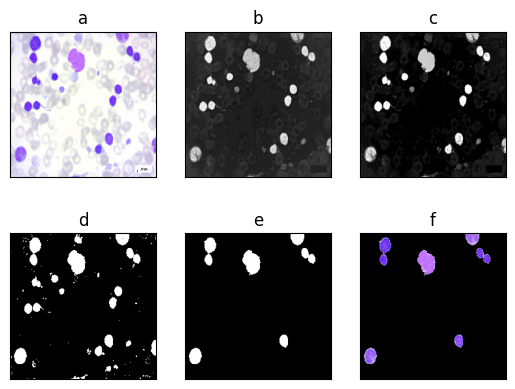

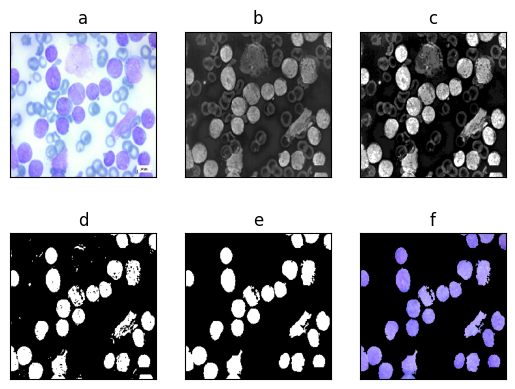

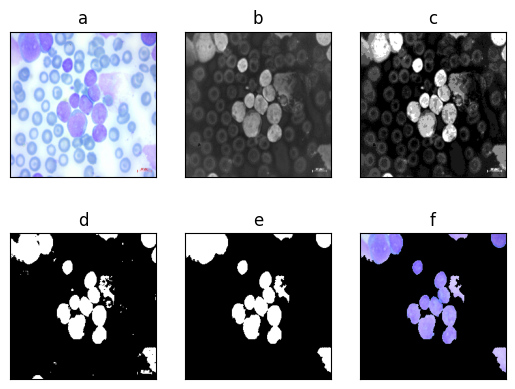

In [8]:
n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)    
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)    
    fh = ndi.binary_fill_holes(t)   
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)  
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)  
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)
    
for j in range(n):    
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()      

# Data Training

In [9]:
prepared_data_path = "/tmp/prepared_test/"
prepared_data_list_filenames = sorted(list(paths.list_images(prepared_data_path)))

if not prepared_data_list_filenames:
    print("Error: No images found in the directory!")
else:
    print(f"Found {len(prepared_data_list_filenames)} images.")

random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    label = os.path.basename(os.path.dirname(line))  # Lấy tên thư mục cha
    prepared_data_list_labels.append(label)

I_series = pd.Series(prepared_data_list_filenames, name="filenames")
L_series = pd.Series(prepared_data_list_labels, name="labels")
test_df = pd.concat([I_series, L_series], axis=1)

print("-- test Dataframe --")
print(test_df.head())

# Đếm số lượng mẫu cho mỗi lớp
a = test_df["labels"].value_counts()
print(a)

Found 325 images.
-- test Dataframe --
                                           filenames     labels
0  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB
1     /tmp/prepared_test/PreB/[Malignant] Pre-B3.png       PreB
2             /tmp/prepared_test/benign/Benign87.png     benign
3   /tmp/prepared_test/PreB/[Malignant] Pre-B134.png       PreB
4  /tmp/prepared_test/EarlyPreB/[Malignant] early...  EarlyPreB
labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64


In [10]:
prepared_data_path = "/tmp/prepared_data/"
prepared_data_list_filenames = sorted(list(paths.list_images(prepared_data_path)))

if not prepared_data_list_filenames:
    print("Error: No images found in the directory!")
else:
    print(f"Found {len(prepared_data_list_filenames)} images.")

random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    label = os.path.basename(os.path.dirname(line))  # Lấy tên thư mục cha
    prepared_data_list_labels.append(label)

I_series = pd.Series(prepared_data_list_filenames, name="filenames")
L_series = pd.Series(prepared_data_list_labels, name="labels")
df = pd.concat([I_series, L_series], axis=1)

print("-- train/valid Dataframe --")
print(df.head())

# Đếm số lượng mẫu cho mỗi lớp
a = df["labels"].value_counts()
print(a)


Found 5834 images.
-- train/valid Dataframe --
                                           filenames     labels
0  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB
1      /tmp/prepared_data/benign/Benign_3935_seg.png     benign
2       /tmp/prepared_data/benign/Benign_297_seg.png     benign
3  /tmp/prepared_data/ProB/[Malignant] Pro-B_3727...       ProB
4  /tmp/prepared_data/EarlyPreB/[Malignant] early...  EarlyPreB
labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


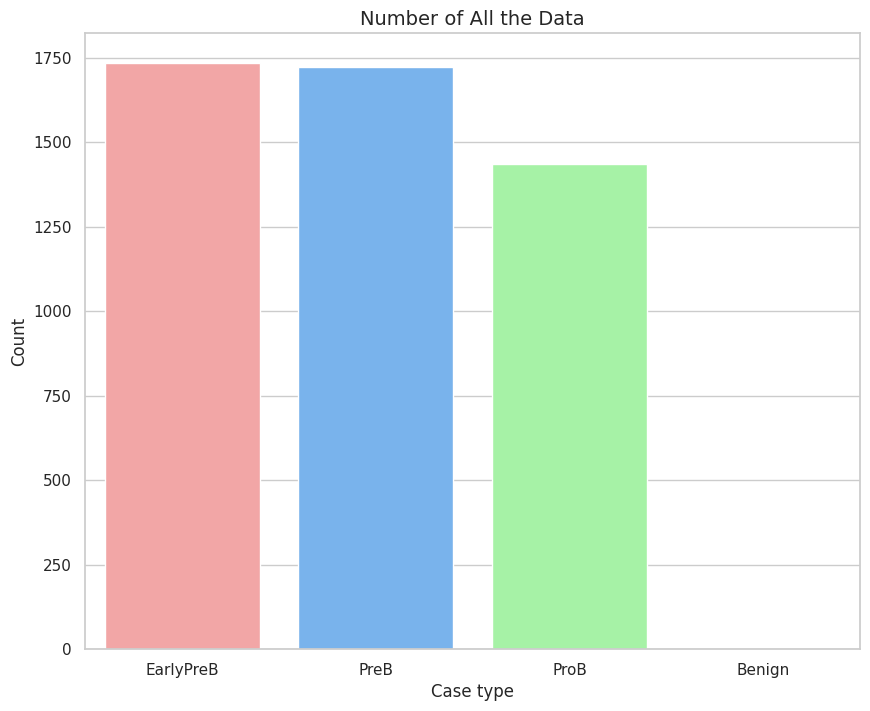

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10,8))

counts = {
    "EarlyPreB": a.get("EarlyPreB", 0),
    "PreB": a.get("PreB", 0),
    "ProB": a.get("ProB", 0),
    "Benign": a.get("Benign", 0)
}

custom_colors = ["#FF9999", "#66B3FF", "#99FF99", "#8B4513"]  

sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette=custom_colors)

plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [12]:
TRAIN_DF, VALID_DF = train_test_split(df, train_size=0.9, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [13]:
test_df['labels'].value_counts()

labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64

In [14]:
BATCH_SIZE= 64
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255, 
                         vertical_flip=True,
                         horizontal_flip=True,
                         # rotation_range=10
                         )

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
82


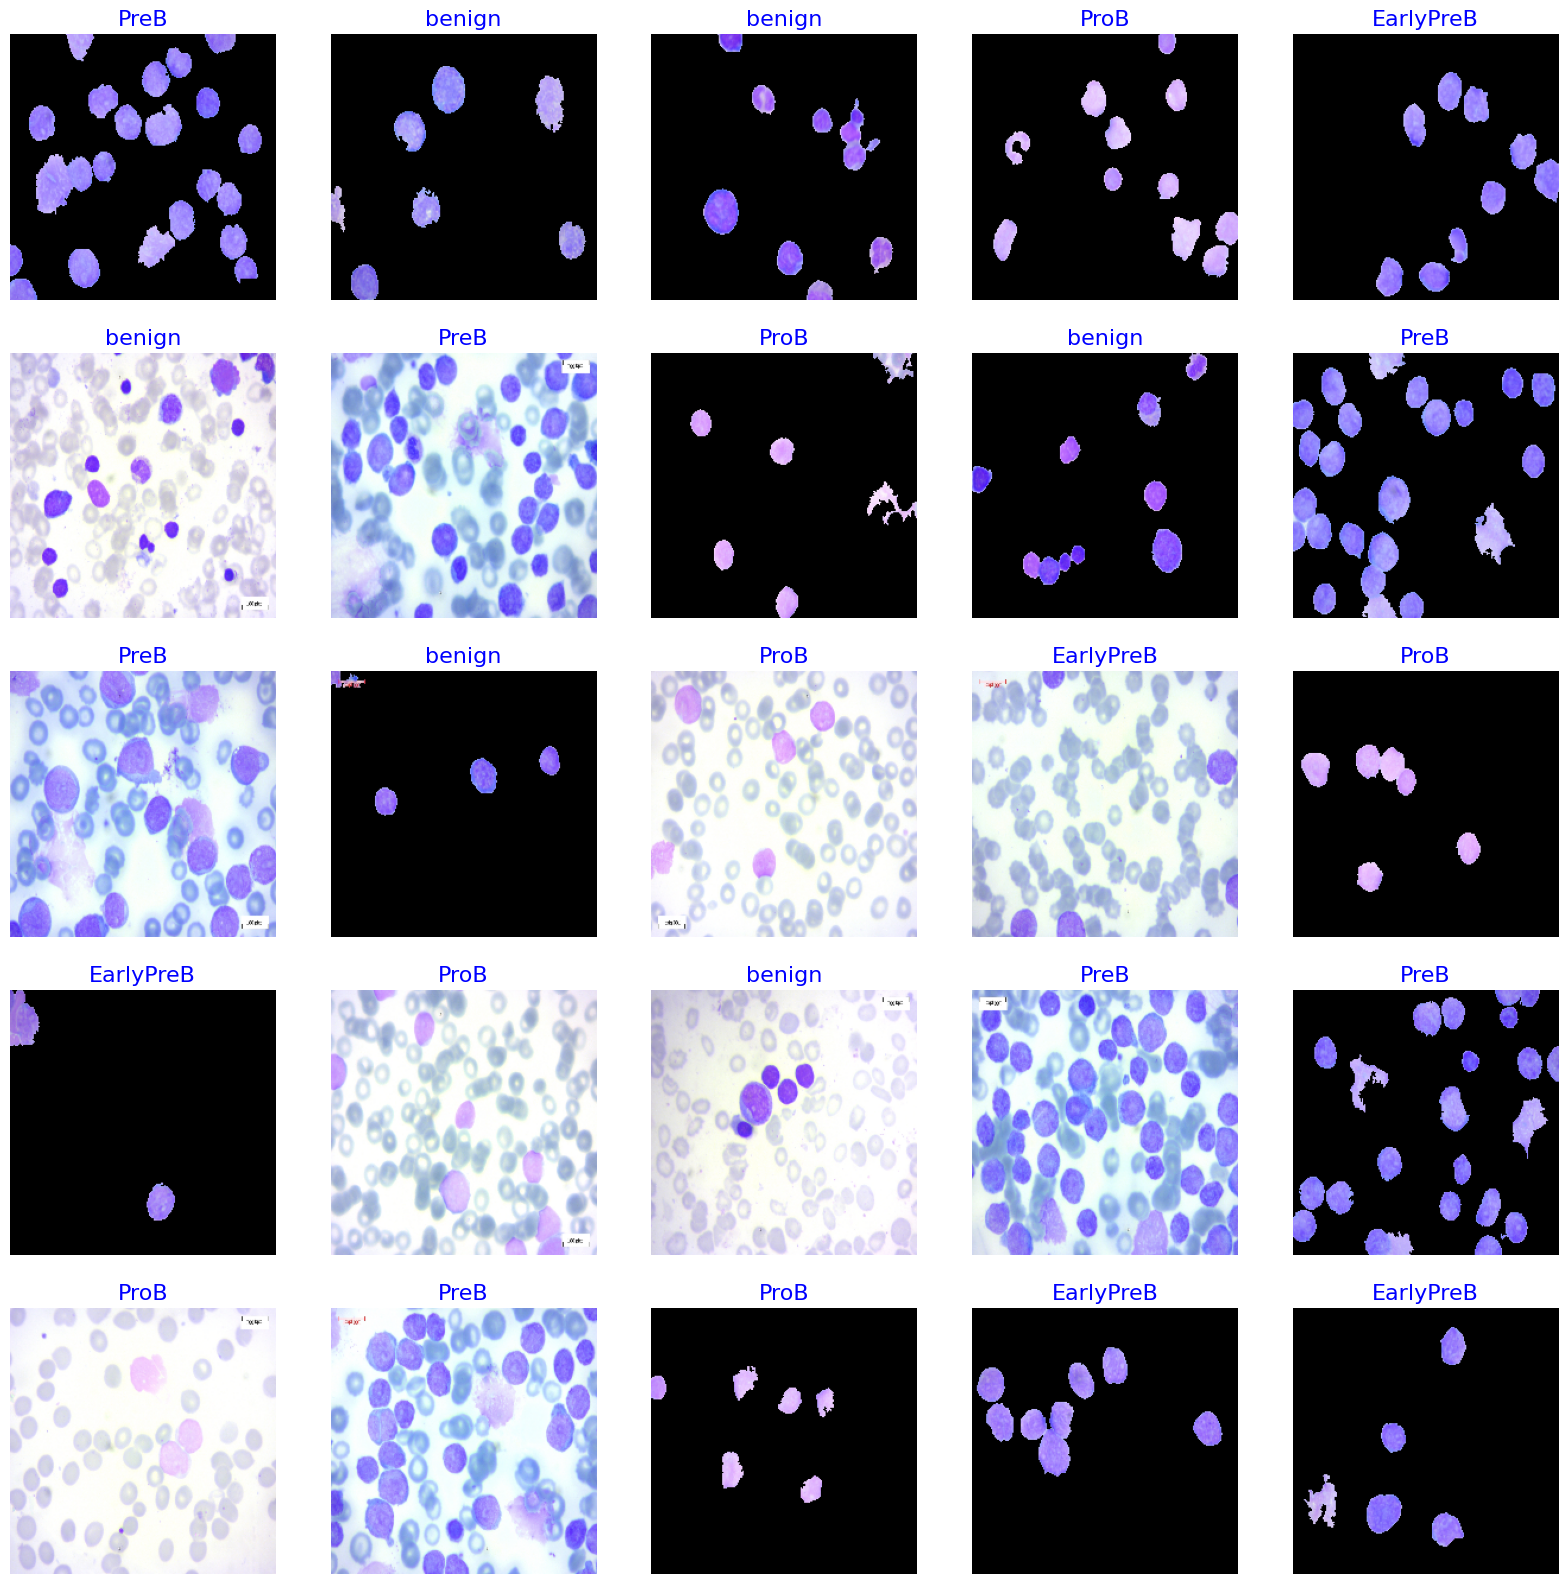

In [15]:
genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) 
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

# EfficientNet

In [16]:
base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) 
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x) 
model = Model(inputs=base_model.input, outputs=predictions) 


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

In [28]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    verbose = 1,
    restore_best_weights = True
)
checkpoint = ModelCheckpoint(
    filepath = "best_model_EfficientNet.keras",
    monitor = 'val_loss',
    save_best_only = True,
    mode = 'min',
    verbose = 1,
) 
callbacks_list = [checkpoint, early_stopping]

In [19]:
history = model.fit(x=train_gen,
                    epochs=70,
                    validation_data=valid_gen,
                    steps_per_epoch=None,
                    # workers=2,
                    callbacks = callbacks_list
                   )

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.6417 - loss: 0.9160
Epoch 1: val_loss improved from inf to 1.37514, saving model to best_model_MobileNet.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 712ms/step - accuracy: 0.6437 - loss: 0.9110 - val_accuracy: 0.3048 - val_loss: 1.3751
Epoch 2/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9537 - loss: 0.1418
Epoch 2: val_loss did not improve from 1.37514
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.9538 - loss: 0.1416 - val_accuracy: 0.3048 - val_loss: 1.4058
Epoch 3/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9683 - loss: 0.0874
Epoch 3: val_loss did not improve from 1.37514
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 230ms/step - accuracy: 0.9683 - loss: 0.0874 - val_accuracy: 0.2603 - val_loss: 1.5511
Epoch 4/70
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9723 - loss: 0.0805
Epoch 4: val_loss did not improve from 1.37514
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 231ms/step - accuracy: 0.9723 - loss: 0.0804 - va

# Results

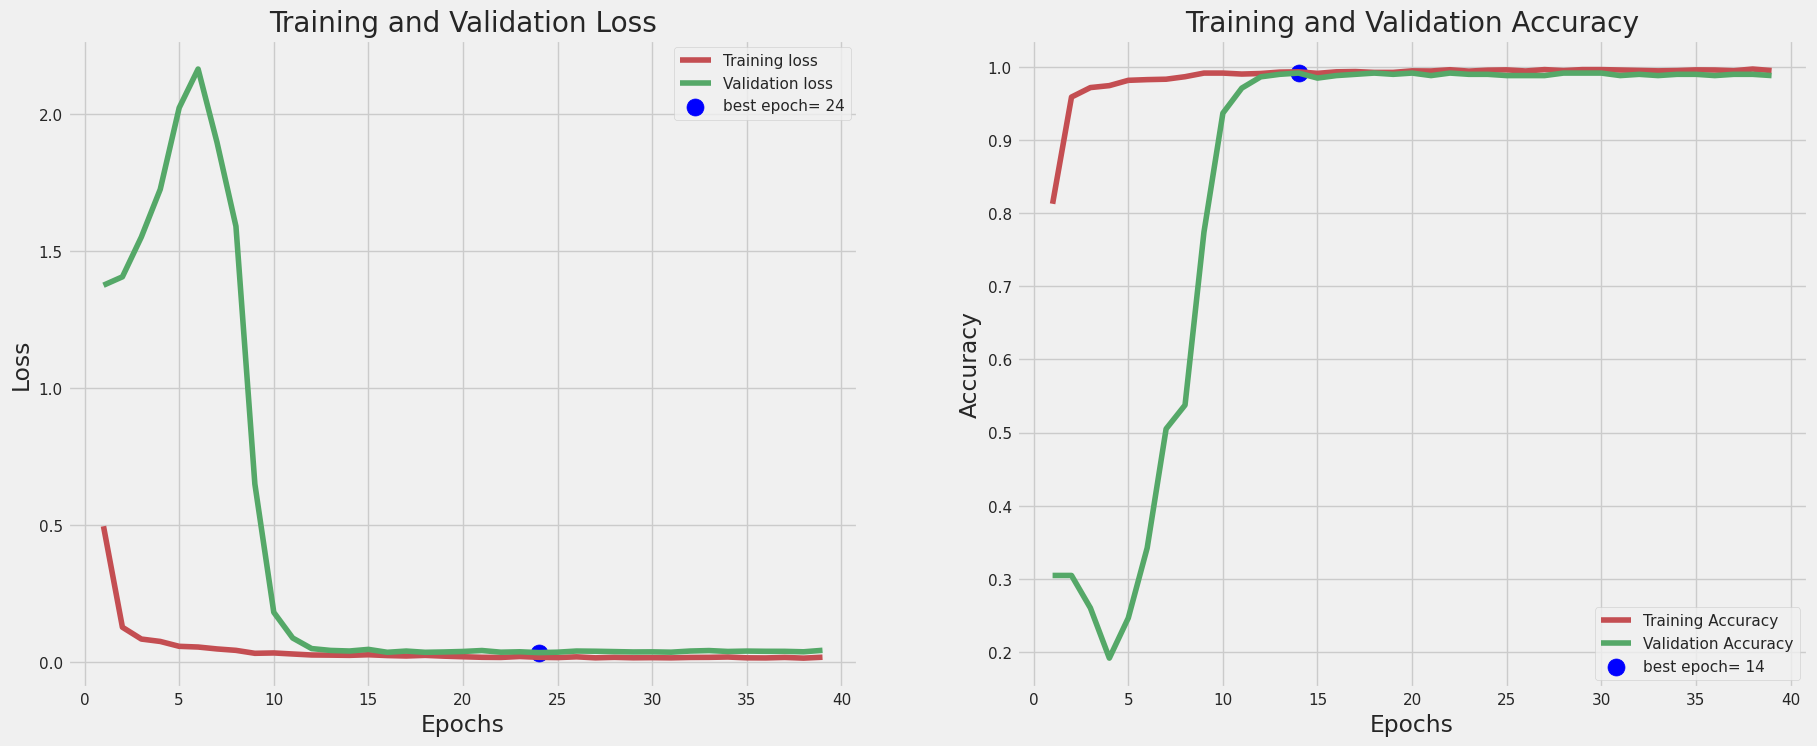

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 1.0000 - loss: 0.0048
Model accuracy on test set: 100.0 (0, 255, 0) (55, 65, 80)


In [20]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
    
    
tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))

In [22]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (325, 4)
test image shape (325, 224, 224, 3)
Evaluate on test-data:
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Confusion Matrix:
 [[111   0   0   0]
 [  0  93   0   0]
 [  0   0  78   0]
 [  0   0   0  43]]


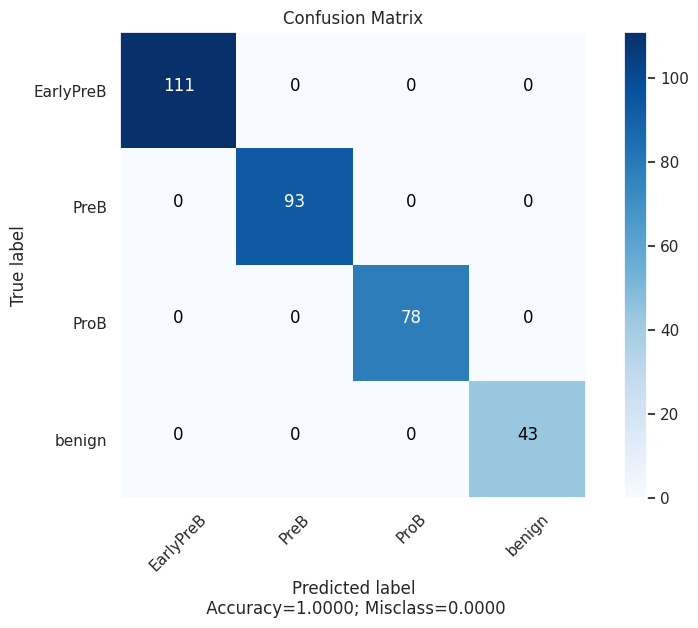

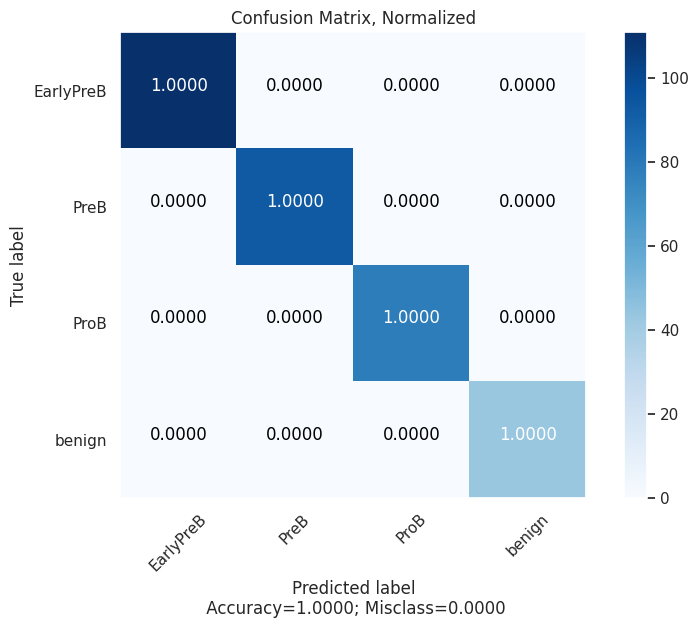

In [23]:
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized")



In [24]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       1.00      1.00      1.00        93

   micro avg       1.00      1.00      1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



# Save Model

In [27]:
import tensorflow as tf

model.save("EfficientNet_model.h5")

model = tf.keras.models.load_model("EfficientNet_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("EfficientNet.tflite", "wb") as f:
    f.write(tflite_model)

print("Done! to save both of file h5 and tflite")

Saved artifact at '/tmp/tmpe5id4i1e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135606723568992: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135606723570048: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135606723570576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723594896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723592608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723595424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723593664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723599296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723598944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135606723600704: TensorSpec(shape=(), dtype=tf.resource, name=None)